# PA004 - HEALTH INSURANCE CROS-SELL

## 0 - IMPORTS AND FUNCTIONS

In [1]:
# Data Analysis and Data Manipulation Libraries
import pandas                  as pd
import numpy                   as np
import seaborn                 as sns
import matplotlib.pyplot       as plt
import plotly.express          as px
import matplotlib.pyplot       as plt
import matplotlib              as mpl
import inflection

# Machine Learning Models
import optuna
from xgboost                   import XGBClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier

from sklearn                   import model_selection as ms
from sklearn.model_selection   import  KFold, StratifiedKFold
from sklearn                   import pipeline

# Metrics and Performance
from sklearn.metrics           import precision_score, roc_auc_score, roc_curve,auc, recall_score
from sklearn.metrics           import precision_recall_curve

# Dysplay
from IPython.core.display    import HTML
from IPython.display         import Image

import warnings
warnings.filterwarnings( 'ignore' )

C:\Users\ricardo\anaconda3\envs\hi_classifier\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.1 - HELPER FUNCTIONS

In [2]:
def eda_analysis (data, features, categorical=False, numerical=False, boxplot=False):
    n_features = len(features)
    n_rows = n_features // 3 + (n_features % 3 > 0) 
        
    fig, axes = plt.subplots(n_rows, 3)  

    for i, feature in enumerate(features):
        row = i // 3  
        col = i % 3  
        ax = axes[row, col] if n_rows > 1 else axes[col]

        if numerical:
            if boxplot:
                sns.boxplot(data=data, x=feature, ax=ax )
                ax.set_title(feature, fontsize=15)  
                ax.set_xlabel('')
            else:
                count_n = data.groupby([feature])[[feature]].count().rename(columns={feature: 'count'}).reset_index()
                count_n['perc'] = count_n['count'] / count_n['count'].sum() * 100

                ax.barh( y=count_n[feature], width=count_n['perc'])

                if pd.api.types.is_numeric_dtype(count_n[feature]):
                    ax.invert_yaxis()

                for index, value in enumerate(count_n['perc']):
                    ax.text(value + 0.5, index, f'{value:.1f}%', va='center') # Adjust the text position based on the width of the bars
                
    
        if categorical:
            dt_count = data.groupby([feature])[[feature]].count().rename(columns={feature: 'count'}).reset_index()
            dt_count['perc'] = dt_count['count'] / dt_count['count'].sum() * 100
            
            ax.barh( y=dt_count[feature], width=dt_count['perc'])
            
            if pd.api.types.is_numeric_dtype(dt_count[feature]):
                ax.invert_yaxis()
            
            for index, value in enumerate(dt_count['perc']):
                ax.text(value + 0.5, index, f'{value:.1f}%', va='center') # Adjust the text position based on the width of the bars
                
            ax.set_yticks(ticks=range(dt_count[feature].nunique()), labels=dt_count[feature].tolist())
            ax.get_xaxis().set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.grid(False)
            
            ax.set_title(feature, fontsize=15)   
            ax.set_xlabel('')  
                
    # Remove unused axes.
    if n_features < len(axes.flat):
        for j in range(n_features, len(axes.flat)):
            fig.delaxes(axes.flat[j])

    plt.tight_layout()

def ml_performance( model_name, precision_atK, recall_atK):
        
        return pd.DataFrame( {'Model Name': model_name,
                              'Precision_at_K': precision_atK,
                              'Recall_at_K': recall_atK}, index=[0] )

def precision_at_k_cv(y_true, proba_predictions, k):
    # Sort the estimated probabilities in descending order.
    sorted_indices = np.argsort(proba_predictions[:, 1])[::-1]
    top_k_indices = sorted_indices[:k]
    
    # Convert the probabilities into binary labels using the top k.
    binary_predictions = np.zeros_like(y_true)
    binary_predictions[top_k_indices] = 1
    
    # Calculate precision at k.
    precision_at_k = precision_score(y_true, binary_predictions)
    
    return precision_at_k

def recall_at_k_cv(y_true, proba_predictions, k):
    # Sort the estimated probabilities in descending order.
    sorted_indices = np.argsort(proba_predictions[:, 1])[::-1]
    top_k_indices = sorted_indices[:k]
    
    # Convert the probabilities into binary labels using the top k.
    binary_predictions = np.zeros_like(y_true)
    binary_predictions[top_k_indices] = 1
    
    # Calculate recall at k
    recall_at_k = recall_score(y_true, binary_predictions)
    
    return recall_at_k

def cross_validation(kfold, modelName, model, X, y, at_k):
    
    # Number of folds
    fold=ms.StratifiedKFold(n_splits = kfold, shuffle=True, random_state=42)
    
    # Performance variables
    precision_list = []
    recall_list = []
    cv_performance = {}
    
    for train_cv,val_cv in fold.split(X, y):
        
        # Separating train and validation dataset for each kfold
        # training data
        x_train_fold = X.iloc[train_cv]
        x_train_fold = x_train_fold
        
        y_train_fold = y.iloc[train_cv]
        y_train_fold = y_train_fold
        
        # validation data
        x_val_fold = X.iloc[val_cv]
        x_val_fold = x_val_fold
        
        y_val_fold = y.iloc[val_cv]
        y_val_fold = y_val_fold
        
        # fitting the model
        model_fitted = model.fit(x_train_fold, y_train_fold)
        
        # getting the prediction probability
        x_val_fold['response'] = y_val_fold
        val_scored = prediction_score(model_fitted, x_val_fold)
        
        # Getting precision and recall at k
        precision = val_scored.loc[at_k, 'precision_at_k']
        recall = val_scored.loc[at_k, 'recall_at_k']
        
        precision_list.append(precision)
        recall_list.append(recall)
        
    # calculating the mean and std performance of all kfolds
    precision_cv = np.round(np.mean(precision_list),4).astype(float)
    std_precision_cv = '+/-' + np.round(np.std(precision_list),4).astype(str)
    recall_cv = np.round(np.mean(recall_list),4).astype(float)
    std_recall_cv = ' +/- ' + np.round(np.std(recall_list),4).astype(str)
        
    cv_performance[modelName] = [precision_cv, std_precision_cv, recall_cv, std_recall_cv]
    model_performance_cv = pd.DataFrame(cv_performance, index=['precision_at_k', 'std_precision', 'recall_at_k', 'std_recall'])

    return model_performance_cv

def prediction_score(model, data):
    # Separating train and validation dataset for each kfold
    x_train = data.drop(columns=['response'])
    y_train = data['response']
    
    # prediction probability (score)
    yhat_proba = model.predict_proba(x_train)[:, 1].tolist()
    
    # merging score to dataset
    data_scored = data.copy()
    data_scored['score'] = yhat_proba
    
    # sort
    data_scored = data_scored.sort_values('score', ascending=False)
    
    # precision and recall
    data_scored = data_scored.reset_index(drop=True)
    data_scored['n_samples'] = data_scored.index + 1
    data_scored['precision_at_k'] = data_scored['response'].cumsum() / data_scored['n_samples']
    data_scored['recall_at_k'] = data_scored['response'].cumsum() / data_scored['response'].sum()
    
    return data_scored

# def jupyter_settings():
    
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', False )
   
#     sns.set()
    
# jupyter_settings()

### Visualization Settings
%matplotlib inline
    
mpl.style.use( 'ggplot' )
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['figure.dpi']          = 120
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 10
mpl.rcParams['figure.figsize']      = [18, 7]
mpl.rcParams['font.size']           = 15

# Palette Setting
color_palette = ['#82B1FF', '#FF9100', '#40C4FF', '#A7FFEB', '#CCFF90', '#616161']

# Setting as the palette
sns.set_palette(sns.color_palette(color_palette))

# Display
sns.color_palette(color_palette)

[(0.5098039215686274, 0.6941176470588235, 1.0),
 (1.0, 0.5686274509803921, 0.0),
 (0.25098039215686274, 0.7686274509803922, 1.0),
 (0.6549019607843137, 1.0, 0.9215686274509803),
 (0.8, 1.0, 0.5647058823529412),
 (0.3803921568627451, 0.3803921568627451, 0.3803921568627451)]

## 1 - LOADING THE DATA

- The dataset was collected from this kaggle competition **https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction**

In [3]:
# Train Datas - Windows
df_raw = pd.read_csv('../data/raw/data.csv')

At the table below you can check the definition for each feature whithin the dataset

| **Variable**         | **Definition**                                                                                                              |
| -------------------- | --------------------------------------------------------------------------------------------------------------------------- |
| id                   | Unique ID for the customer                                                                                                  |
| Gender               | Gender of the customer                                                                                                      |
| Age                  | Age of the customer                                                                                                         |
| Driving_License      | 0 : Customer does not have DL, 1 : Customer already has DL                                                                  |
| Region_Code          | Unique code for the region of the customer                                                                                  |
| Previously_Insured   | 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance                                     |
| Vehicle_Age          | Age of the Vehicle                                                                                                          |
| Vehicle_Damage       | 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.          |
| Annual_Premium       | The amount customer needs to pay as premium in the year                                                                     |
| Policy_Sales_Channel | Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. |
| Vintage              | Number of Days, Customer has been associated with the company                                                               |
| Response             | 1 : Customer is interested, 0 : Customer is not interested                                                                  |

### 1.1 - DATA DIMENSIONS

In [4]:
df1 = df_raw.copy()

In [5]:
# Data Dimensions
print( 'The dataset contains {}'.format( df1.shape[0] ),'rows.' )
print( 'The dataset contains {}'.format( df1.shape[1] ),'columns.' )

The dataset contains 381109 rows.
The dataset contains 12 columns.


In [6]:
# Data Types
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
dtype: object

**Some of the data are with the wrong data type:**
   - **id**: is an identification for each customer, so each line has an unique value and we cannot use at math operations. I will change the data type from integer to string;
   - **region_code**: is an identification of the region where each customer is from and we cannot use at math operations. I will change the data type from integer to string;
   - **policy_sales_channel**: is an identification of the channel used to contact the customer and this cannot be used for math operations. I will change the data type from integer to string;  


In [7]:
# # Changing Data Types
# df1['id'] = df1['id'].astype( str ) # ID of each customer
# df1['region_code'] = df1['region_code'].astype( str ) # Code of region, we cannot do maths operations with these values
# df1['policy_sales_channel'] = df1['policy_sales_channel'].astype( str ) # Code of sales channel, we cannot do maths operations with these values

In [8]:
# Data Types
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
dtype: object

In [9]:
# Check NAN Values
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

There are no missing values on this dataset.

In [10]:
# Duplicated Values
df1.duplicated().sum()

0

There are no duplicated values on this dataset.

### 1.2 - DATA DESCRIPTIVE

To describe the datas, I will create two new dataframes:
- num_attributes: contains the features that could be used on math operations, such as: integer and float;
- cat_attributes: contains categorical features;

In [11]:
# Select columns where the content is different 0 or 1.
# numerical features
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
#num_attributes = df1[['id','age','region_code','policy_sales_channel','annual_premium','vintage']]

# categorical features
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])
#cat_attributes = df1[['gender','vehicle_age']]

#### 1.2.1 - NUMERICAL VARIABLES

In [12]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


Insights:

- **age**: Looking into the min and max values, it is possible to identify that the customers vary from 20 years old to 85 years old, where most part of them are younger than 40 years old, however the data is scattered between this interval.
- **anual_premium**: Looking into the min and max, the values have a high variation and more information about the business is necessary to understand if these values are consistent. The avg value is far from the max value recorded and also the value is scattered, it causes a high standard deviation. It would be good to get more information about the business to have a better understanding about the value.
- **vintage**: Analysing the min and max it is possible to identify that the customers are within the company from 10 days to 299 days. Around half oof them are within the company for less than 6 months however, the data is spread into this interval.

### 1.3 - DATASET SPLIT

In [13]:
# Checking if the data is imbalanced
df1['response'].value_counts(normalize=True)

response
0    0.877437
1    0.122563
Name: proportion, dtype: float64

- I will split the data into train, validation and test datasets.
- I will perform EDA focusing on the training set in order to avoid data leakage, get a realistic representation and evaluate the model correctly with new unseen data.
- I will specify stratify=y so that the train_test_split function ensures that the splitting process maintains the same percentage of each target class in both the training and testing sets. This is useful when dealing with imbalanced datasets.

In [14]:
# Split dataset into train, test and validation datasets
X = df_raw.drop( ['response'], axis=1 )
y = df_raw['response'].copy()
x_train, x_valid, y_train, y_valid = ms.train_test_split( X, y, test_size=0.20, stratify=y, random_state=42 )
x_train, x_test, y_train, y_test   = ms.train_test_split( x_train, y_train, test_size=0.25, stratify=y_train, random_state=42 )

print(f" x_train: {x_train.shape}\n y_train: {y_train.shape}\n x_valid: {x_valid.shape}\n y_valid: {y_valid.shape}\n x_test: {x_test.shape}\n y_test: {y_test.shape}\n")

 x_train: (228665, 11)
 y_train: (228665,)
 x_valid: (76222, 11)
 y_valid: (76222,)
 x_test: (76222, 11)
 y_test: (76222,)



In [55]:
print(y_train.value_counts(normalize=True))
print(y_valid.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

response
0    0.877436
1    0.122564
Name: proportion, dtype: float64
response
0    0.877437
1    0.122563
Name: proportion, dtype: float64
response
0    0.877437
1    0.122563
Name: proportion, dtype: float64


## 2 - FEATURE ENGINEERING

From this step, all process will be applied to the training dataset only. Afterwards an fuction will be created to apply everything to the others datasets.

In [16]:
df2 = pd.concat([x_train, y_train], axis=1)

## 3 - DATA FILTERING

In [17]:
df3 = df2.copy()

## 4 - EXPLORATORY DATA ANALYSIS (EDA)

In [18]:
df4 = df3.copy()

In [19]:
cat_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

### 4.1 - UNIVARIATE AND BIVARIATE ANALYSIS

#### 4.1.1 -  Num. Feature: region_code

**region_code** : is a unique code for the region of the customer.

Analysing the charts, some regions stands out than others in volum of customers, what could be used as an insight for future projects;

The top 5 region_code with high volum of customers are:
1. region code 28: 60000 customers approximately;
2. region code 8: 20000 customers approximately;
3. region code 46: 11000 customers approximately.
4. region code 41: 11000 customers approximately.
5. region code 15: 8000 customers approximately.

Almost 40% of the customers are from these 5 regions. This could be a valuable data for the company.

**There is too much data**, I will divide in two charts.

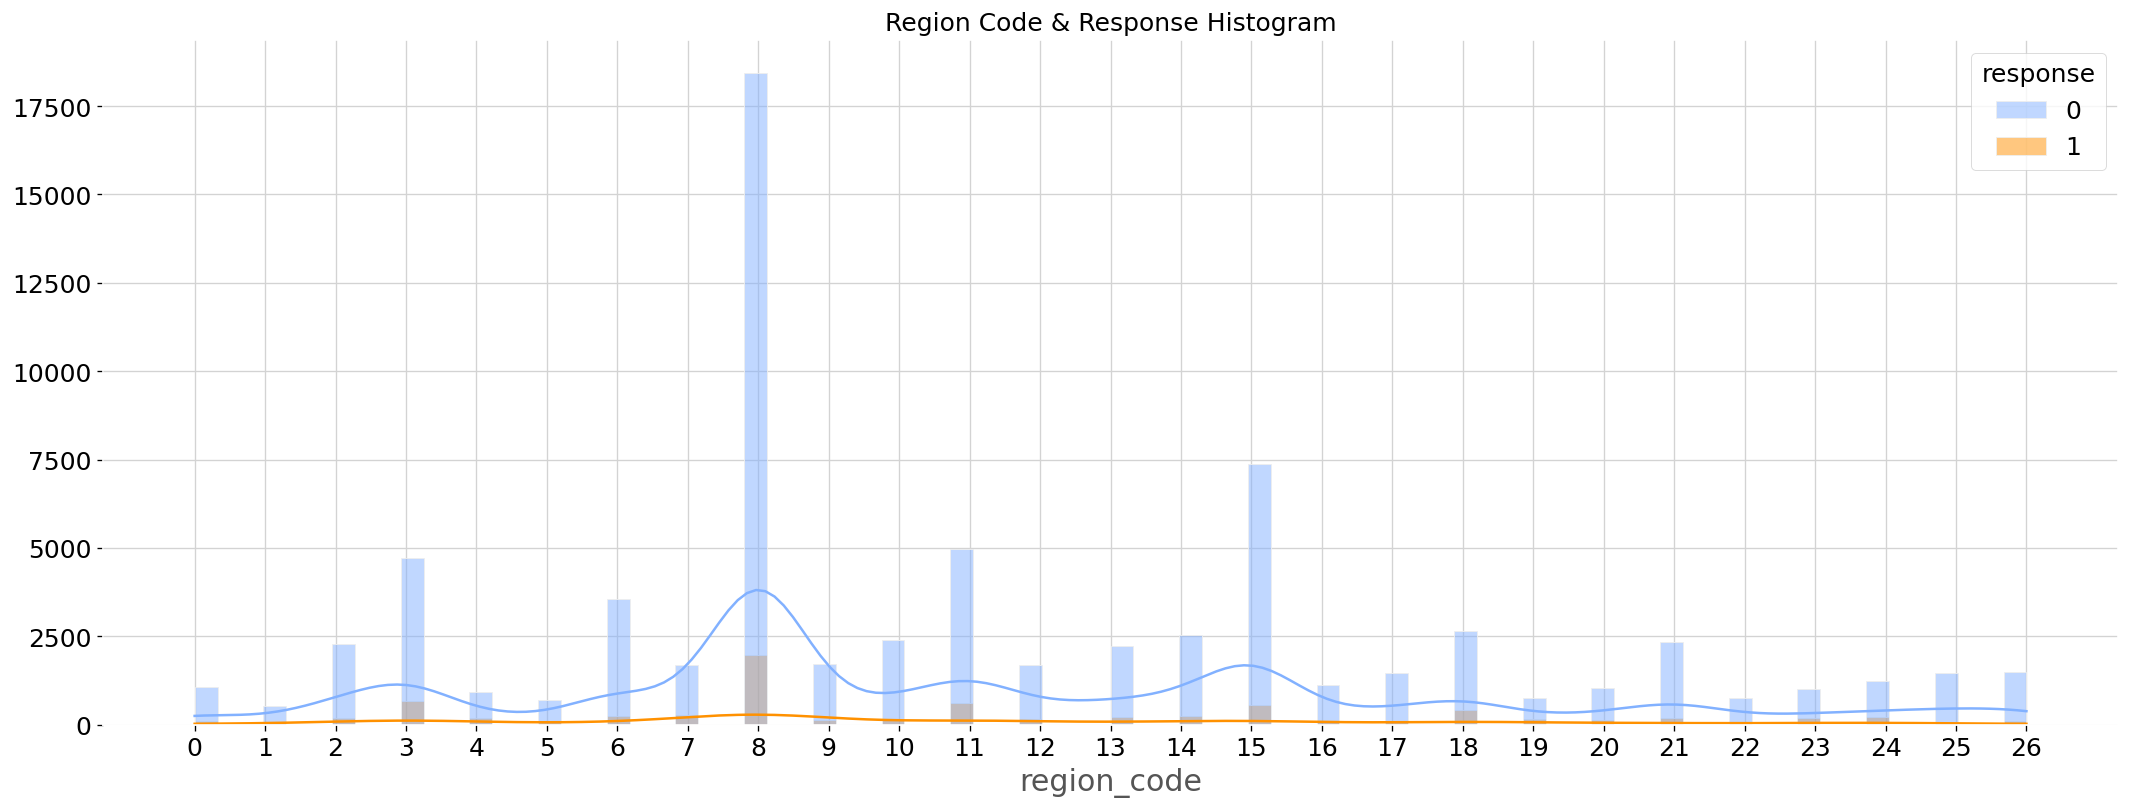

In [20]:
# Select the region code from 0 to 26
df_rc26 = df4[df4['region_code'] <= 26]

# Chart creation
sns.histplot(data=df_rc26, x='region_code', kde=True, hue='response')

# Obtaining the values for'region_code'
unique_region_codes = sorted(df_rc26['region_code'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_region_codes)

# Title and laayout
plt.title('Region Code & Response Histogram', fontsize=15)
plt.ylabel('')
plt.tight_layout()

# Plot
plt.show()

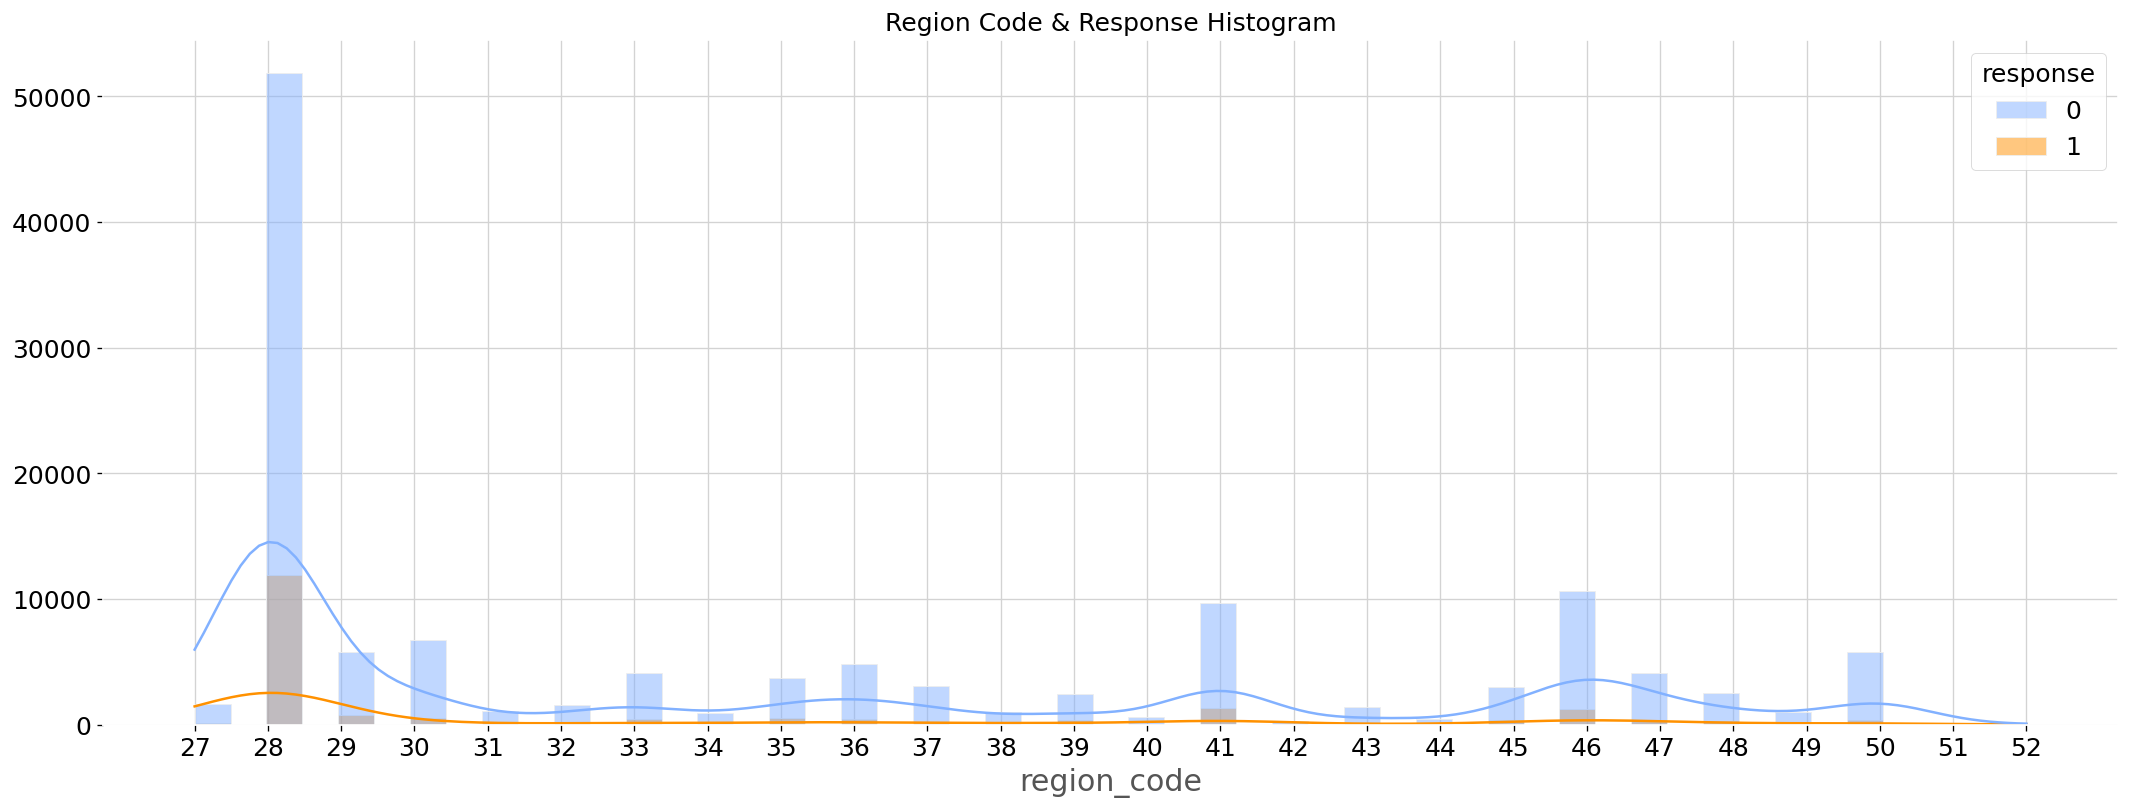

In [21]:
# Select the region code from 0 to 26
df_rc52 = df4[df4['region_code'] > 26]

# Chart creation
sns.histplot(data=df_rc52, x='region_code', kde=True, hue='response')

# Obtaining the values for'region_code'
unique_region_codes = sorted(df_rc52['region_code'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_region_codes)

# Title and laayout
plt.title('Region Code & Response Histogram', fontsize=15)
plt.ylabel('')
plt.tight_layout()

# Plot
plt.show()

#### 4.1.2 - Num. Feature: policy_sales_channel

**policy sales channel**: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

Taking a look into the charts for this feature, it is possible to identify that some channel stand out from the others. The top 5 channel with a high volum of customers are:

1. policy sales channel 152: 80000 customers approximatelly.
2. policy sales channel 26: 50000 customers approximatelly.
3. policy sales channel 124: 44000 customers approximatelly.
4. policy sales channel 160: 13000 customers approximatelly.
5. policy sales channel 156: 6500 customers approximatelly.


More than 70% of the customers are from these 5 channel, and approximately 75% of the interested customers are within these channel. This is also a valuable information for the company, where they can analyse if it is necessary to have a range of more than 160 ways to contact customers when 5 of them hold the high volum of customers.

**There are also too much data**, my approach will be same as above, I will divide the content in eight graphs.

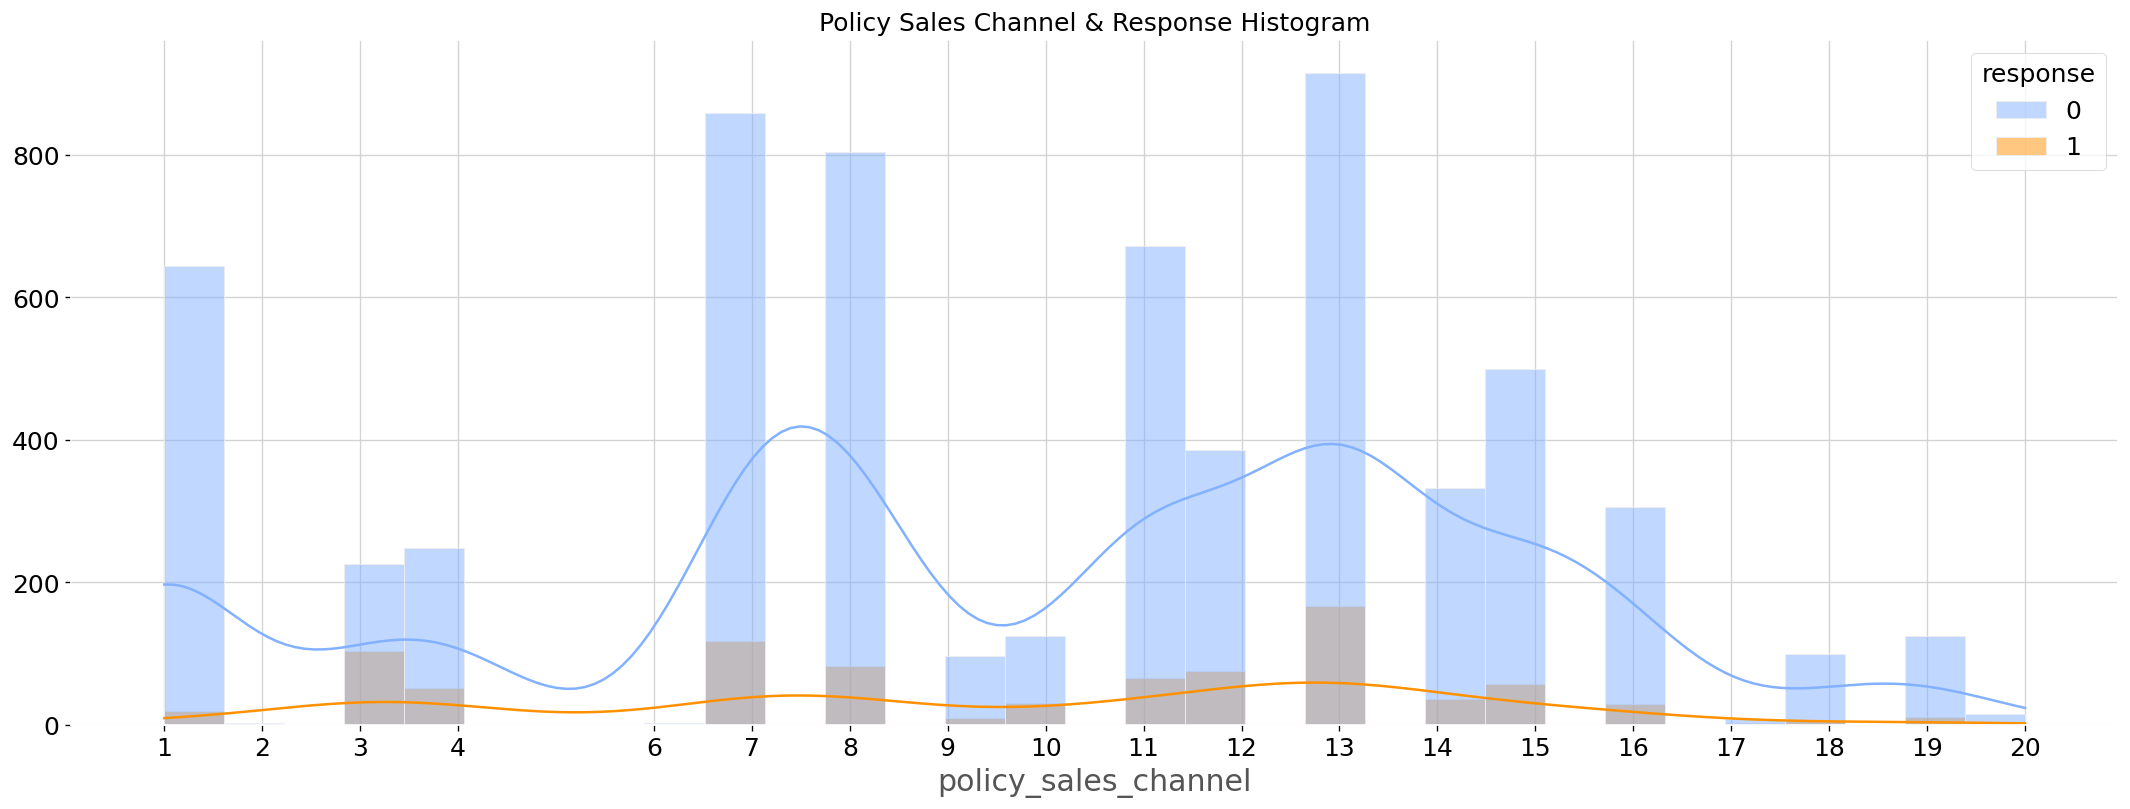

In [22]:
# Select the policy_sales_channel
df_psc20 = df4[df4['policy_sales_channel'] <= 20]

# Chart creation
sns.histplot(data=df_psc20, x='policy_sales_channel', kde=True, hue='response')

# Obtaining the values for'region_code'
unique_region_codes = sorted(df_psc20['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_region_codes)

# Title and laayout
plt.title('Policy Sales Channel & Response Histogram', fontsize=15)
plt.ylabel('')
plt.tight_layout()

# Plot
plt.show()

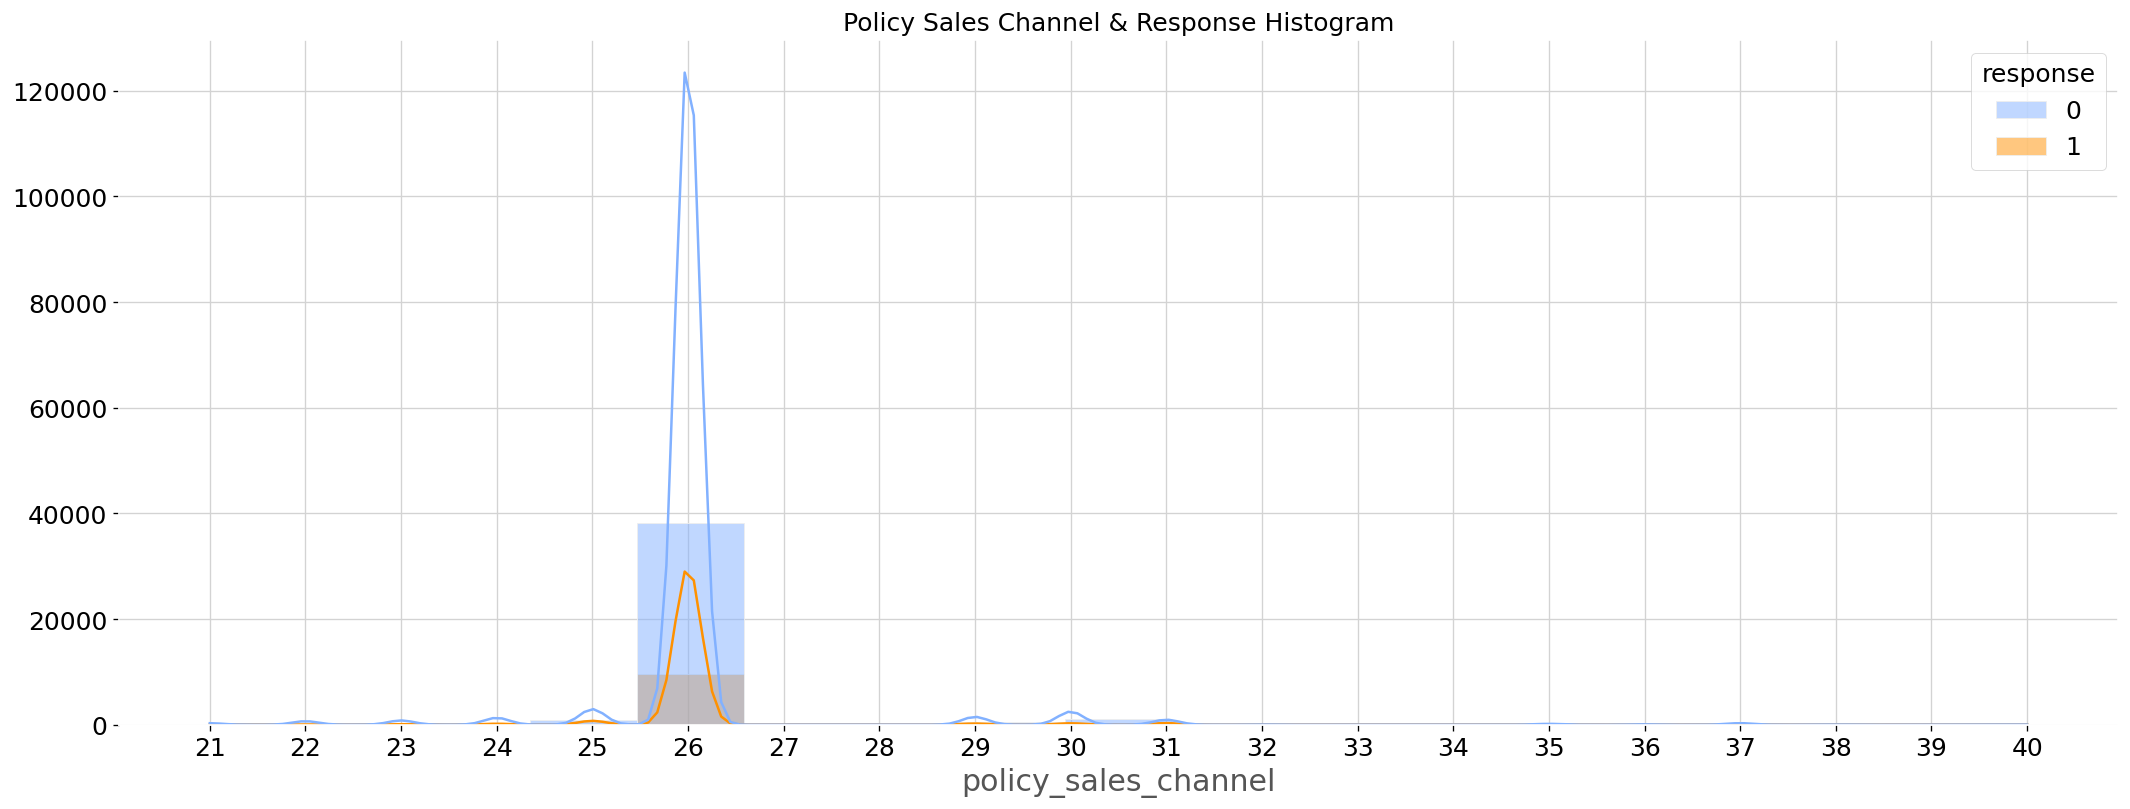

In [23]:
# Select the policy_sales_channel
df_psc40 = df4[ (df4['policy_sales_channel'] > 20) & (df4['policy_sales_channel'] <= 40)]

# Chart creation
sns.histplot(data=df_psc40, x='policy_sales_channel', kde=True, hue='response')

# Obtaining the values for'region_code'
unique_region_codes = sorted(df_psc40['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_region_codes)

# Title and laayout
plt.title('Policy Sales Channel & Response Histogram', fontsize=15)

plt.ylabel('')
plt.tight_layout()

# Plot
plt.show()

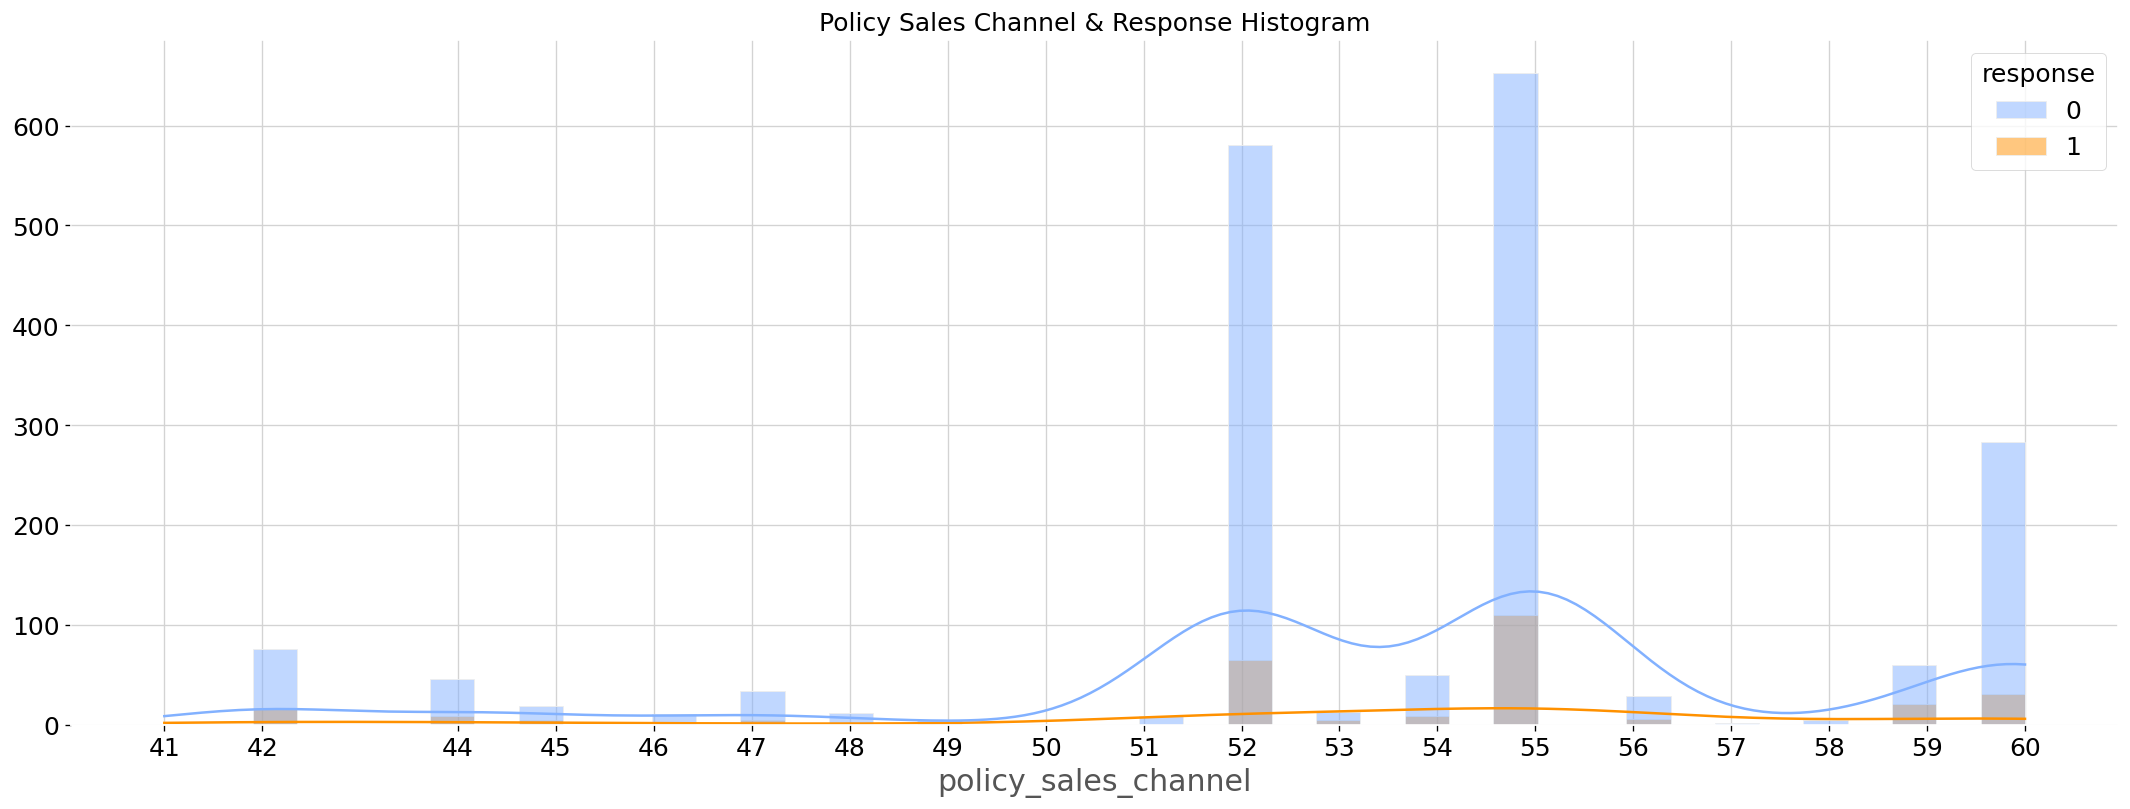

In [24]:
# Select the policy_sales_channel
df_psc60 = df4[ (df4['policy_sales_channel'] > 40) & (df4['policy_sales_channel'] <= 60)]

# Chart creation
sns.histplot(data=df_psc60, x='policy_sales_channel', kde=True, hue='response')

# Obtaining the values for'region_code'
unique_region_codes = sorted(df_psc60['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_region_codes)

# Title and laayout
plt.title('Policy Sales Channel & Response Histogram', fontsize=15)
plt.ylabel('')
plt.tight_layout()

# Plot
plt.show()

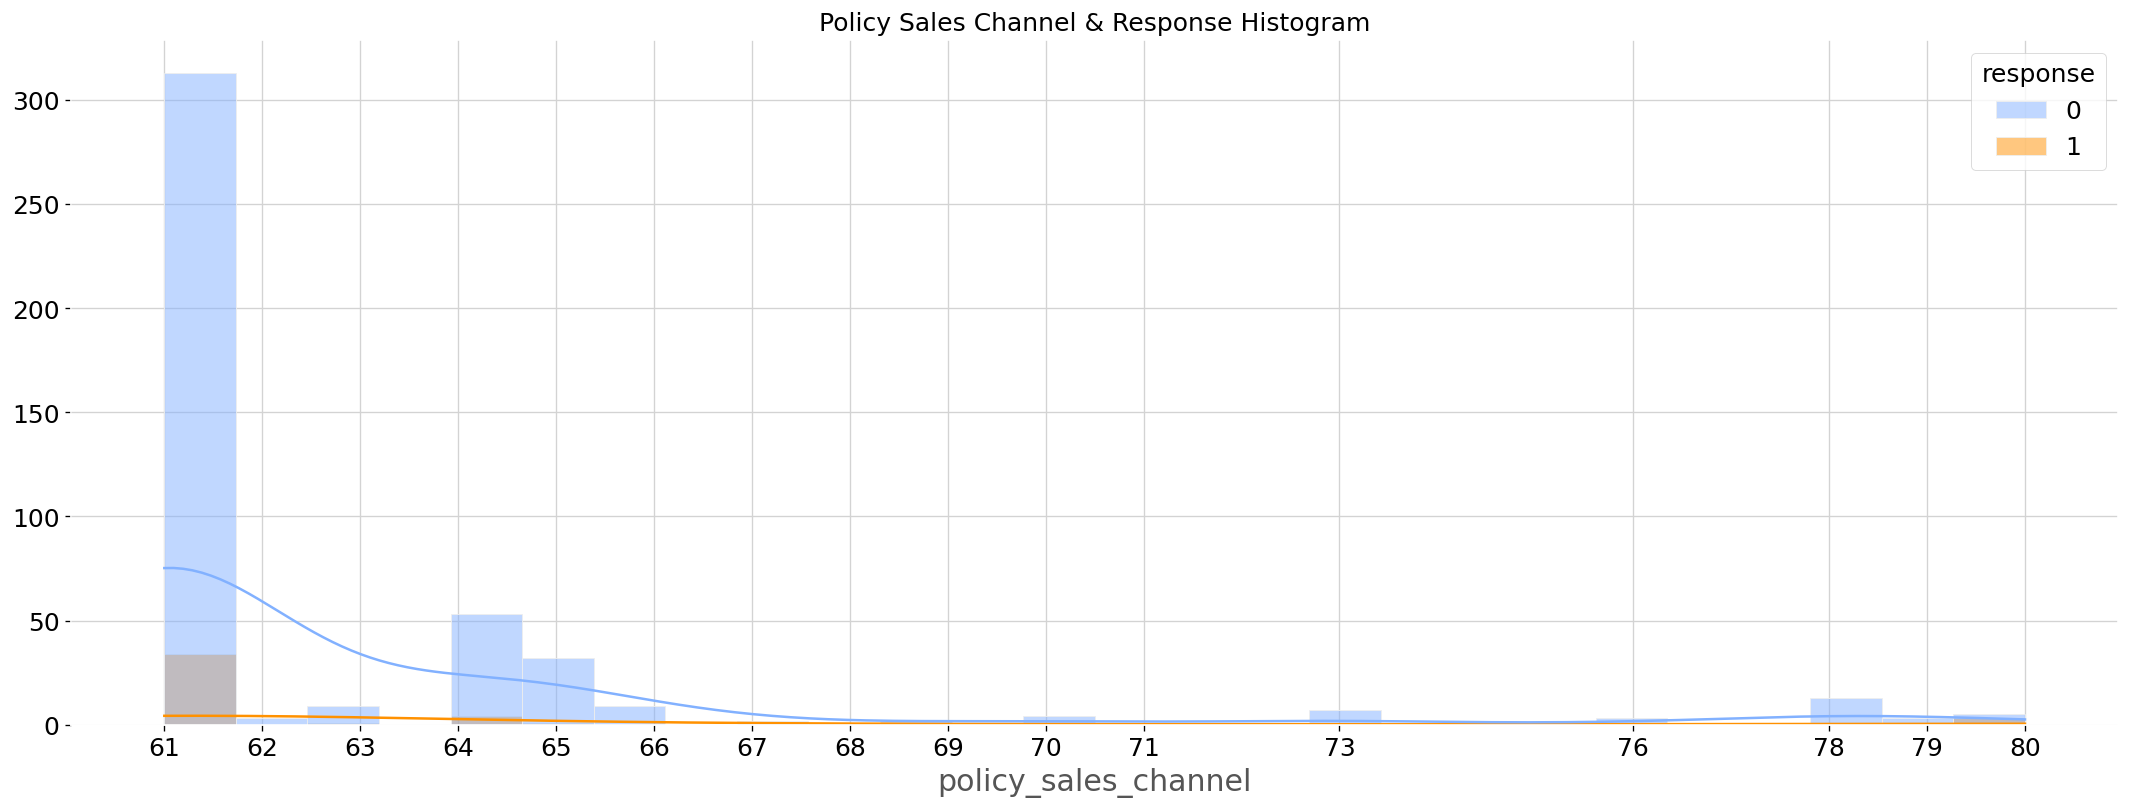

In [25]:
# Select the policy_sales_channel
df_psc80 = df4[ (df4['policy_sales_channel'] > 60) & (df4['policy_sales_channel'] <= 80)]

# Chart creation
sns.histplot(data=df_psc80, x='policy_sales_channel', kde=True, hue='response')

# Obtaining the values for'region_code'
unique_region_codes = sorted(df_psc80['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_region_codes)

# Title and laayout
plt.title('Policy Sales Channel & Response Histogram', fontsize=15)
plt.ylabel('')
plt.tight_layout()

# Plot
plt.show()

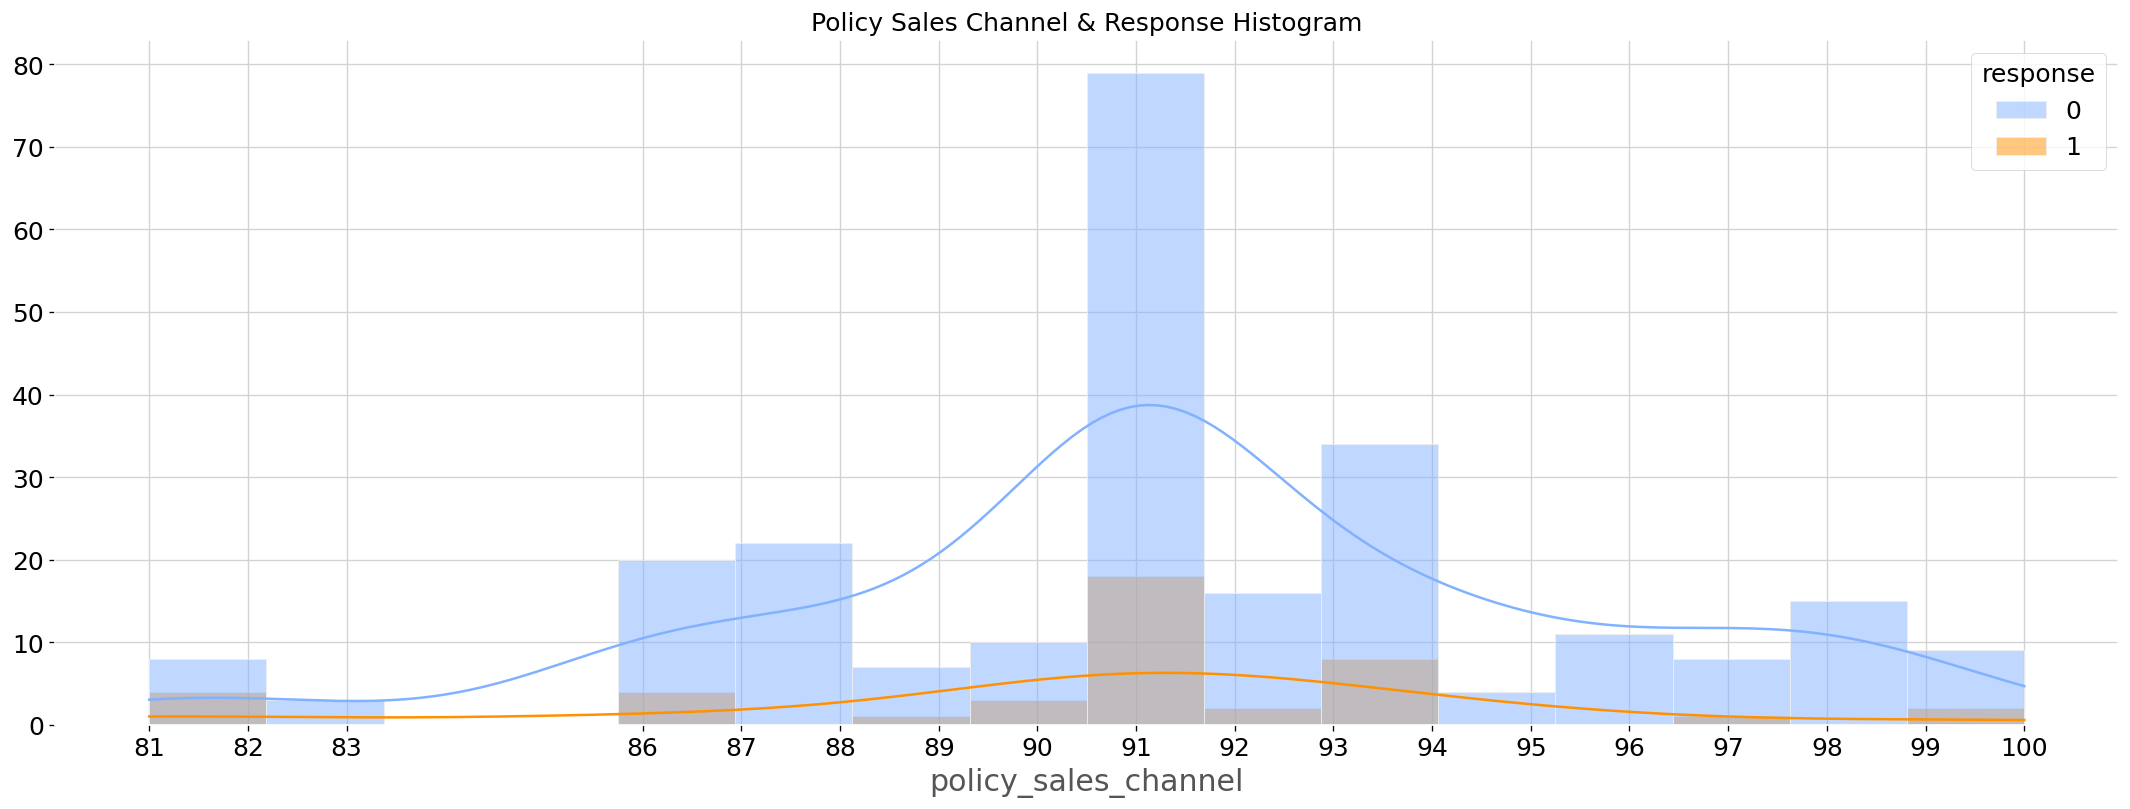

In [26]:
# Select the policy_sales_channel
df_psc100 = df4[ (df4['policy_sales_channel'] > 80) & (df4['policy_sales_channel'] <= 100)]

# Chart creation
sns.histplot(data=df_psc100, x='policy_sales_channel', kde=True, hue='response')

# Obtaining the values for'region_code'
unique_region_codes = sorted(df_psc100['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_region_codes)

# Title and laayout
plt.title('Policy Sales Channel & Response Histogram', fontsize=15)
plt.ylabel('')
plt.tight_layout()

# Plot
plt.show()

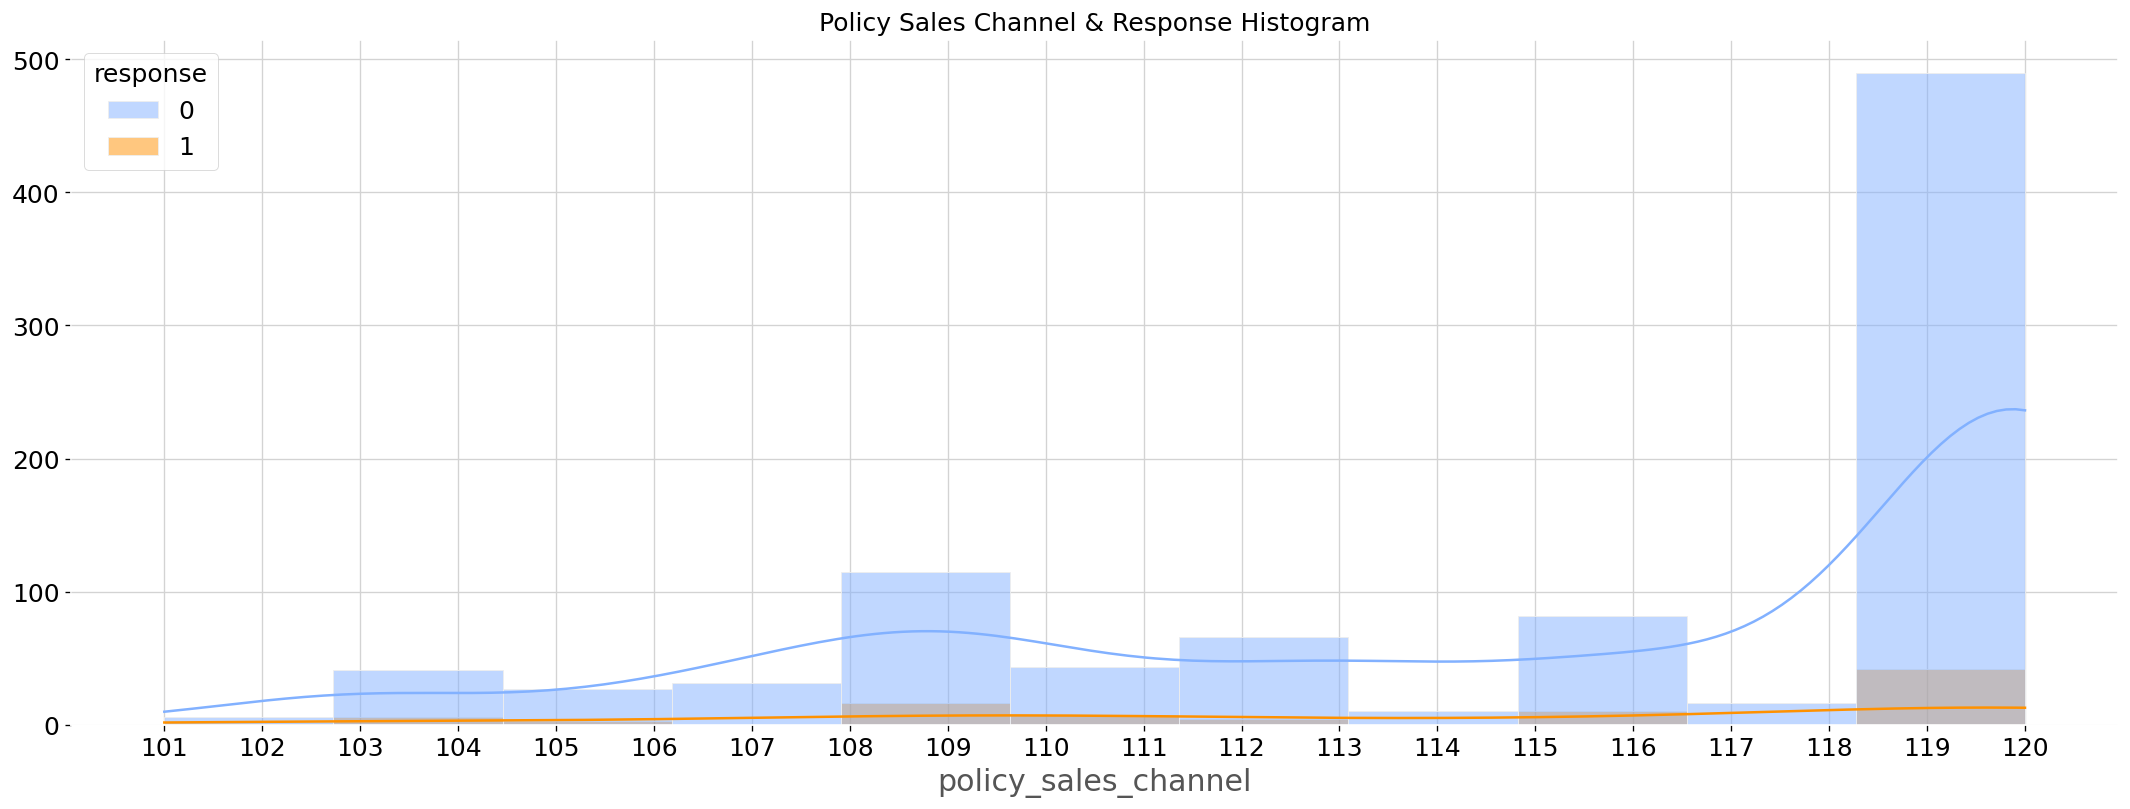

In [27]:
# Select the policy_sales_channel
df_psc120 = df4[ (df4['policy_sales_channel'] > 100) & (df4['policy_sales_channel'] <= 120)]

# Chart creation
sns.histplot(data=df_psc120, x='policy_sales_channel', kde=True, hue='response')

# Obtaining the values for'region_code'
unique_region_codes = sorted(df_psc120['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_region_codes)

# Title and laayout
plt.title('Policy Sales Channel & Response Histogram', fontsize=15)
plt.ylabel('')
plt.tight_layout()

# Plot
plt.show()

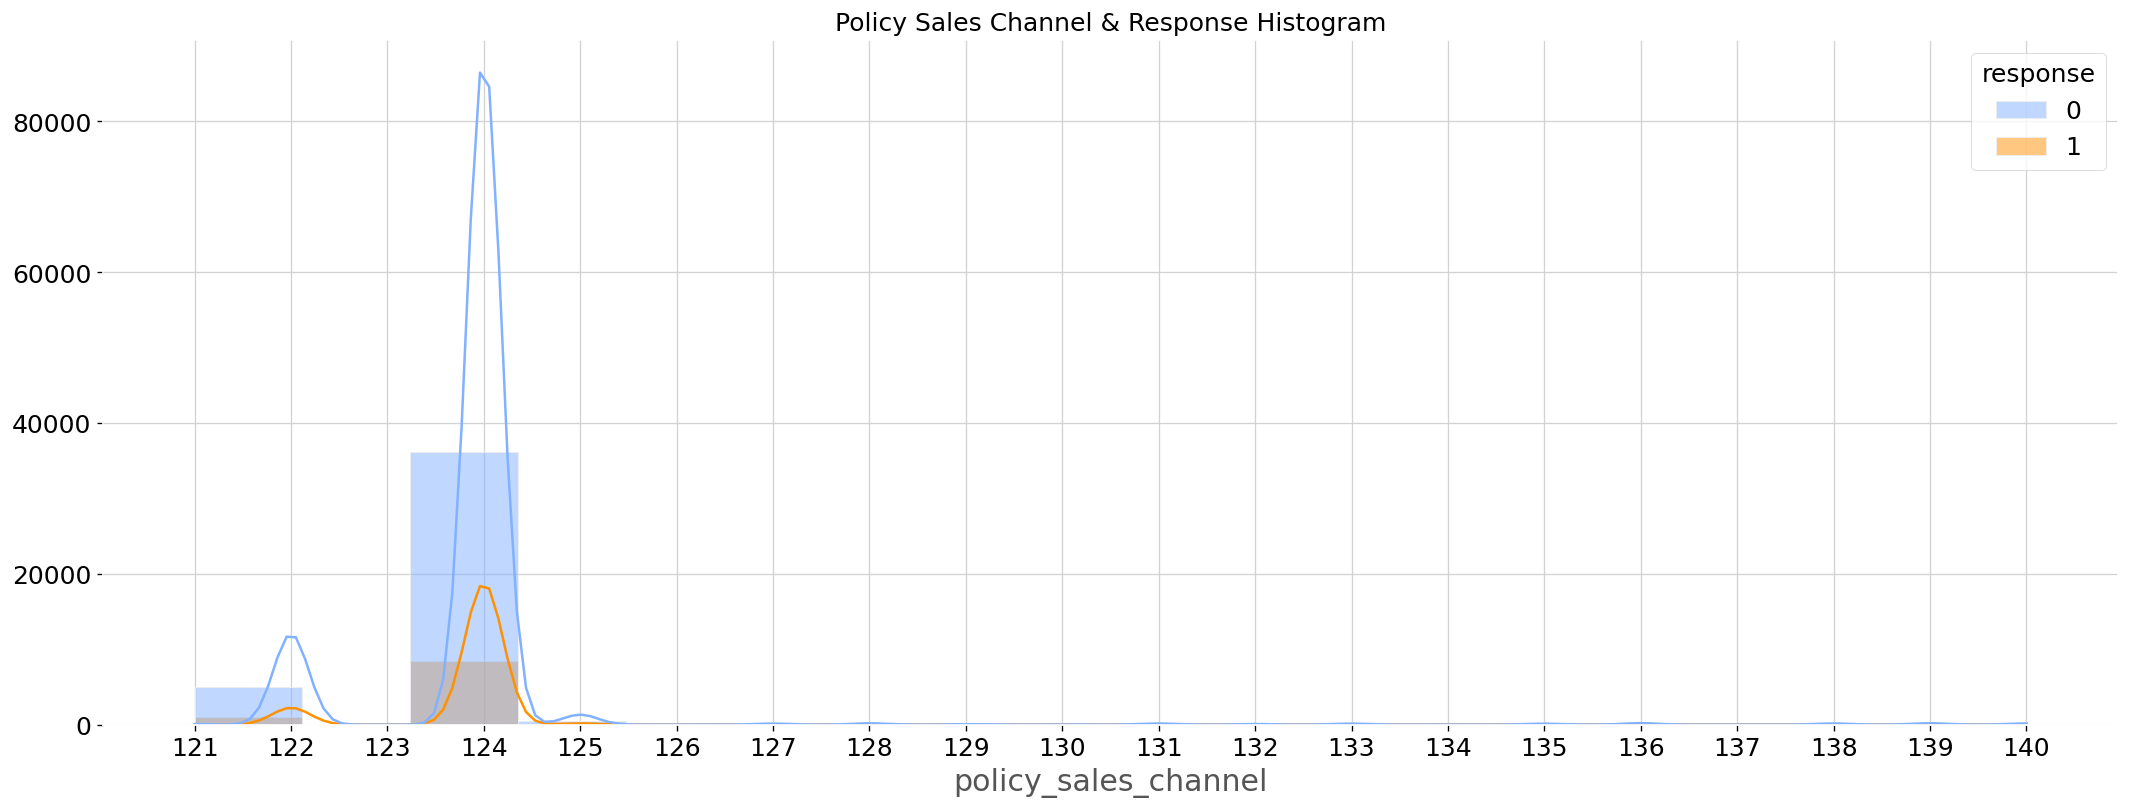

In [28]:
# Select the policy_sales_channel
df_psc140 = df4[ (df4['policy_sales_channel'] > 120) & (df4['policy_sales_channel'] <= 140)]

# Chart creation
sns.histplot(data=df_psc140, x='policy_sales_channel', kde=True, hue='response')

# Obtaining the values for'region_code'
unique_region_codes = sorted(df_psc140['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_region_codes)

# Title and laayout
plt.title('Policy Sales Channel & Response Histogram', fontsize=15)
plt.ylabel('')
plt.tight_layout()

# Plot
plt.show()

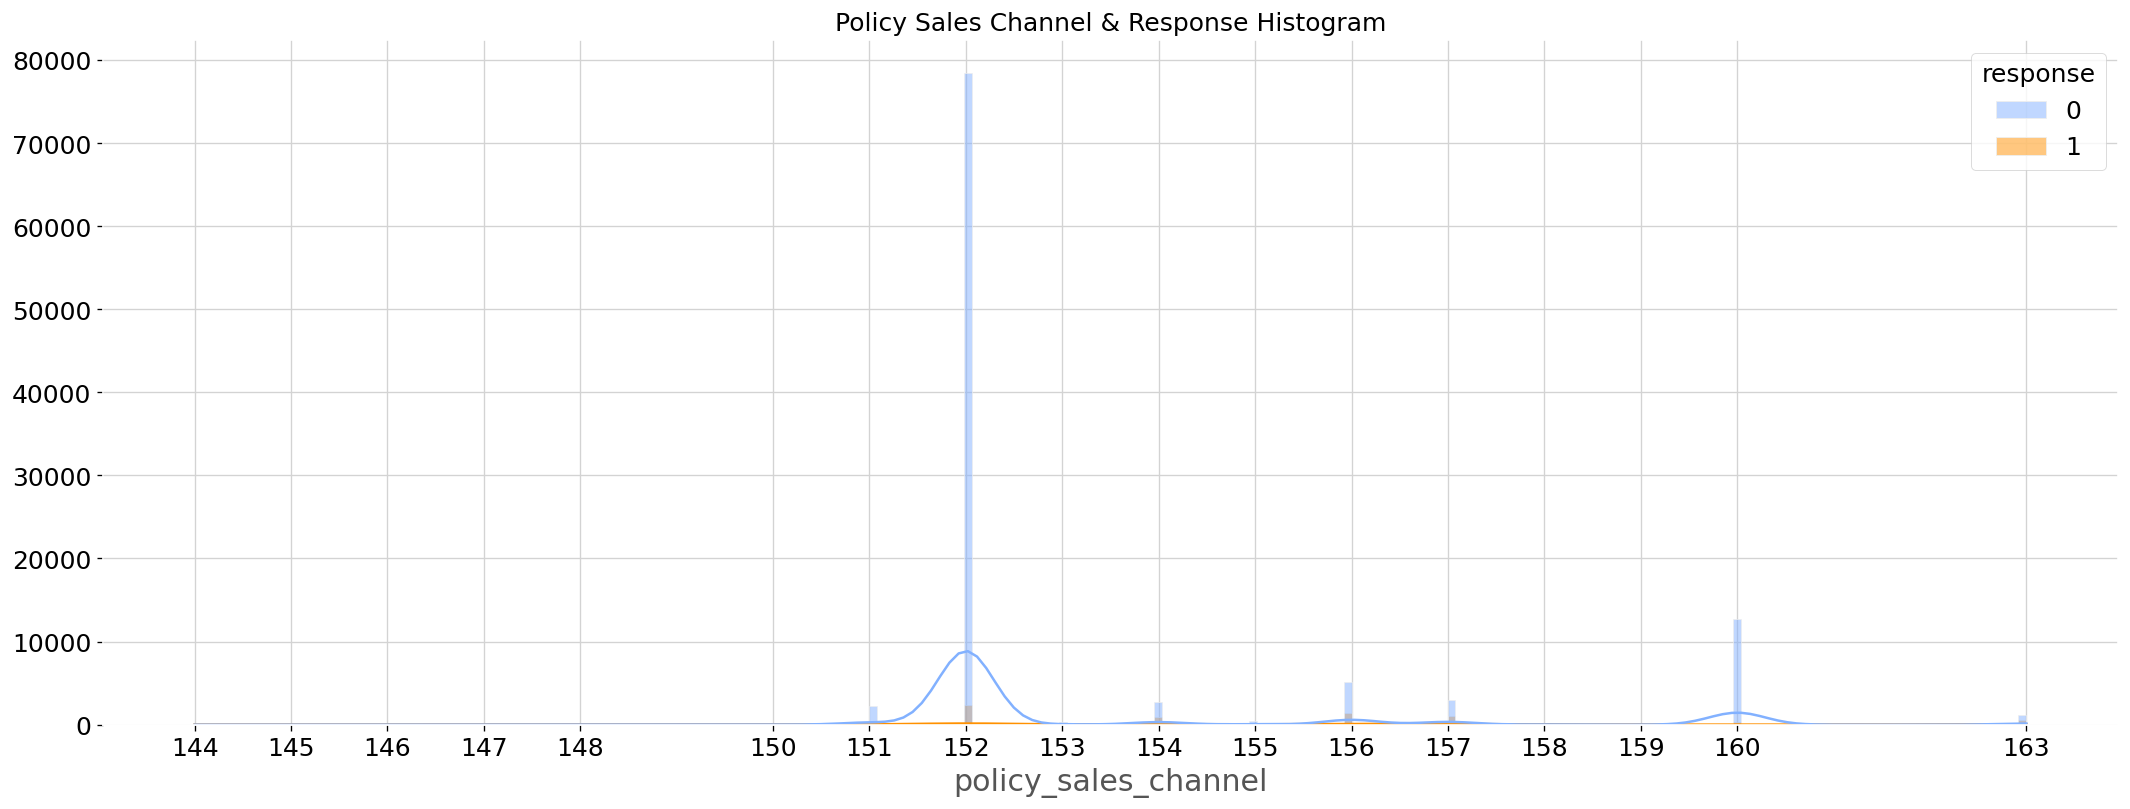

In [29]:
# Select the policy_sales_channel
df_psc160 = df4[ (df4['policy_sales_channel'] > 140) & (df4['policy_sales_channel'] <= 200)]

# Chart creation
sns.histplot(data=df_psc160, x='policy_sales_channel', kde=True, hue='response')

# Obtaining the values for'region_code'
unique_region_codes = sorted(df_psc160['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_region_codes)

# Title and laayout
plt.title('Policy Sales Channel & Response Histogram', fontsize=15)
plt.ylabel('')
plt.tight_layout()

# Plot
plt.show()

#### 4.1.3 - Num. Feature: driving_license

It is possible to identify that almost all clients have driving license. However there are a small number of customers that own a car but does not have driving license. The company could consider promotions or strategies to attract more customers with this profile.

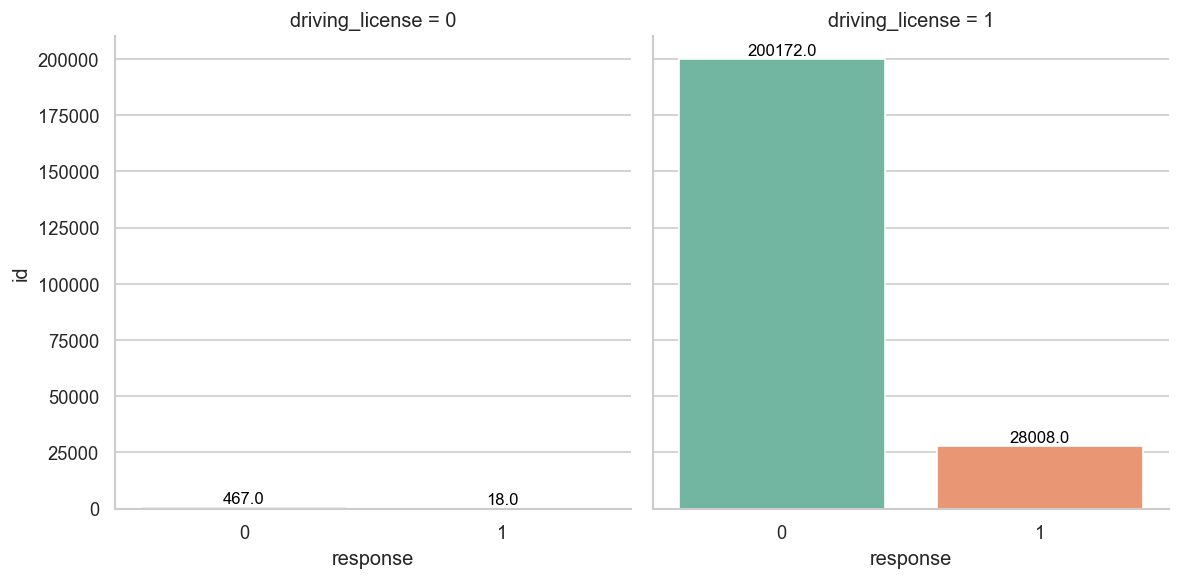

In [139]:
# Couting the data
df_dl = df4[['id','driving_license','response']].groupby(['driving_license','response']).count().reset_index()

# Creating the chart
g = sns.catplot(
    data=df_dl, x="response", y="id", col="driving_license",
    kind="bar", height=5, aspect=1, palette="Set2"
)

# Adding labels on the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Plot
plt.show()

#### 4.1.4 - Num.  Feature: previously_insured

The largest volume of customers had been insured, however the ones that had not been insured before shows an greater interest in buying the new product. Another insight where the company can adopt strategies or promotions to attract more customers with both profiles.

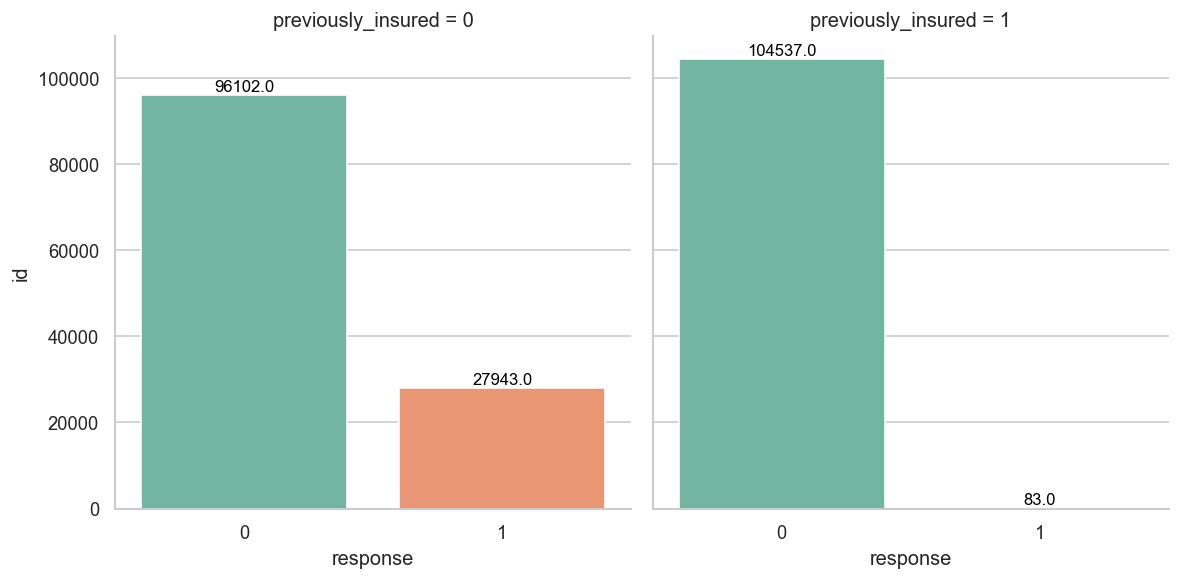

In [140]:
# Couting the data
df_pi = df4[['id','previously_insured','response']].groupby(['previously_insured','response']).count().reset_index()

# Creating the chart
g_pi = sns.catplot(
                    data=df_pi, x="response", y="id", col="previously_insured",
                    kind="bar", height=5, aspect=1, palette="Set2"
)

# Adding labels on the bars
for ax in g_pi.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Plot
plt.show()

#### 4.1.5 - Num. Feature: vintage

I can't see much relevant information on this chart, the only thing is kind of a pattern on the dates and volum of customers that the company absorves.

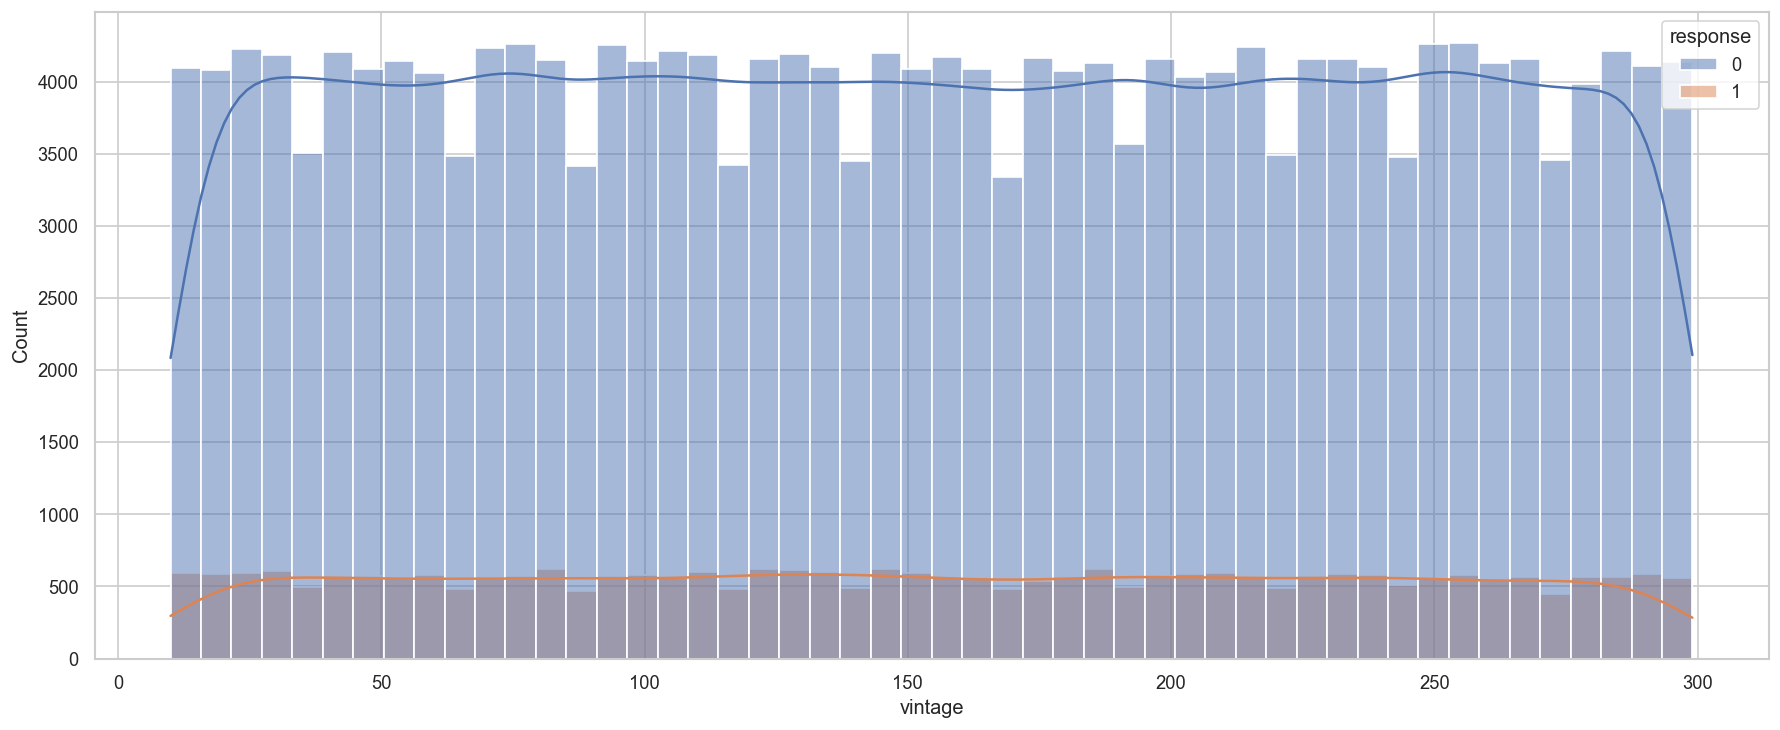

In [148]:
# Chart creation
sns.histplot(data=df4, x='vintage', kde=True, hue='response', bins=50);

#### 4.1.6 - Num. Feature: annual_premium

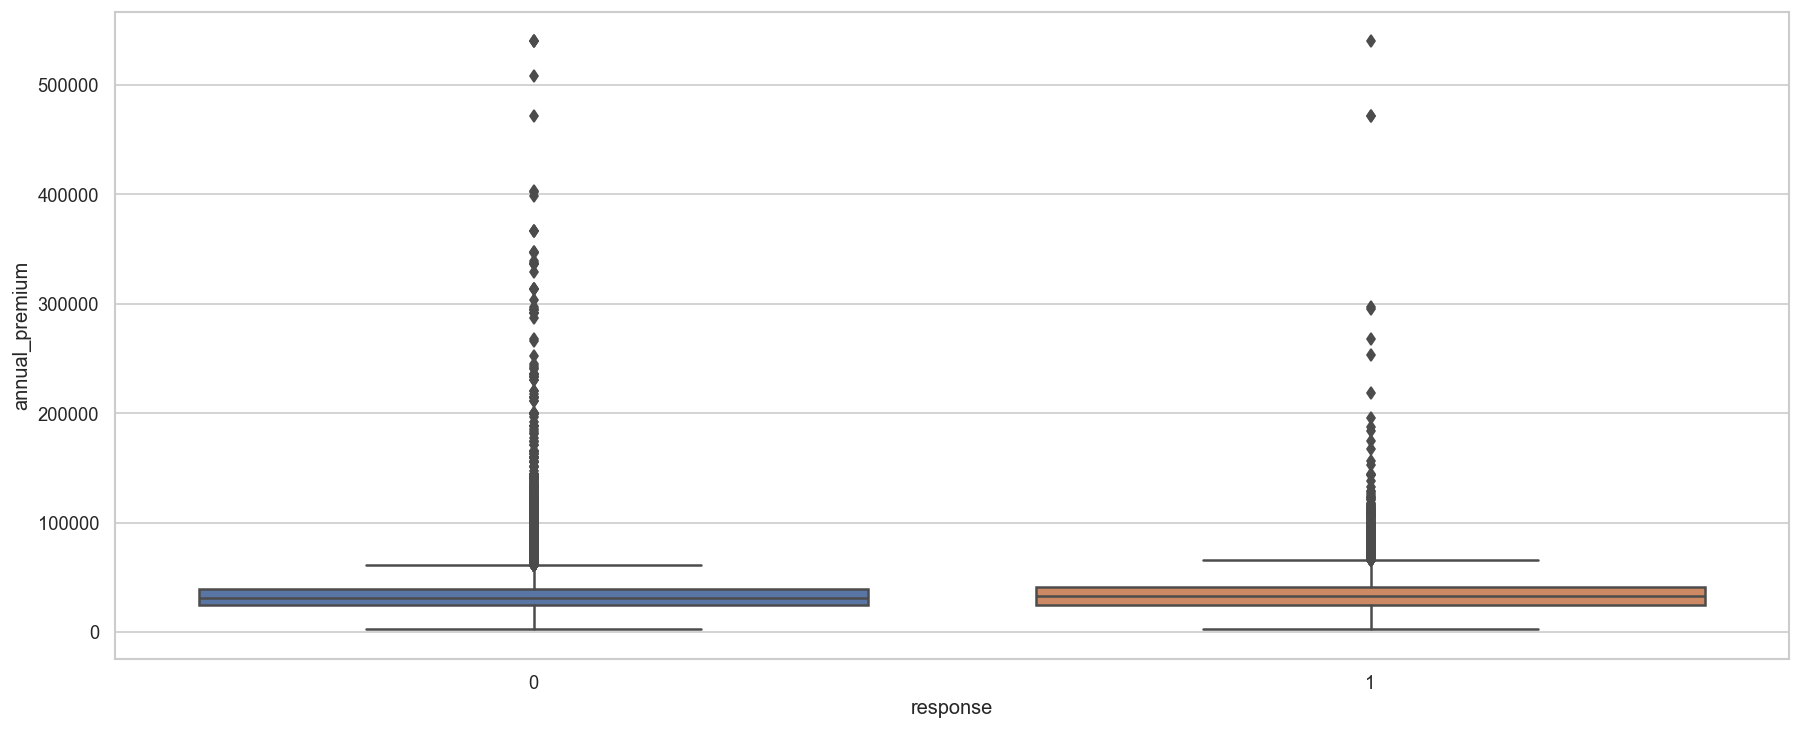

In [152]:
sns.boxplot(data=df4, x='response',y='annual_premium');

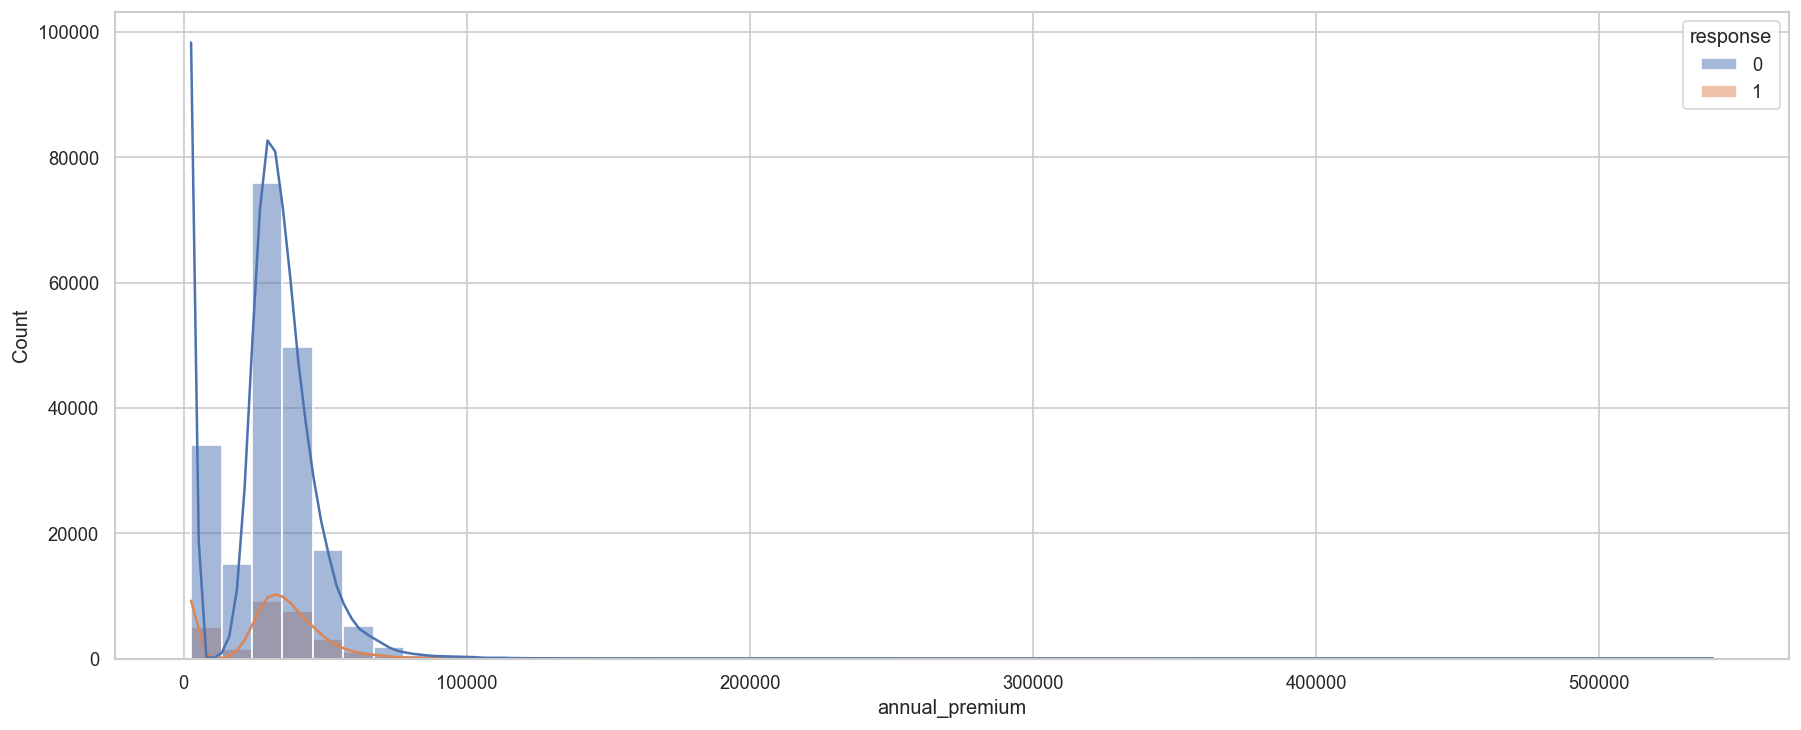

In [153]:
sns.histplot(data=df4, x='annual_premium', kde=True, hue='response', bins=50);

#### 4.1.7 - Num. Feature: Age

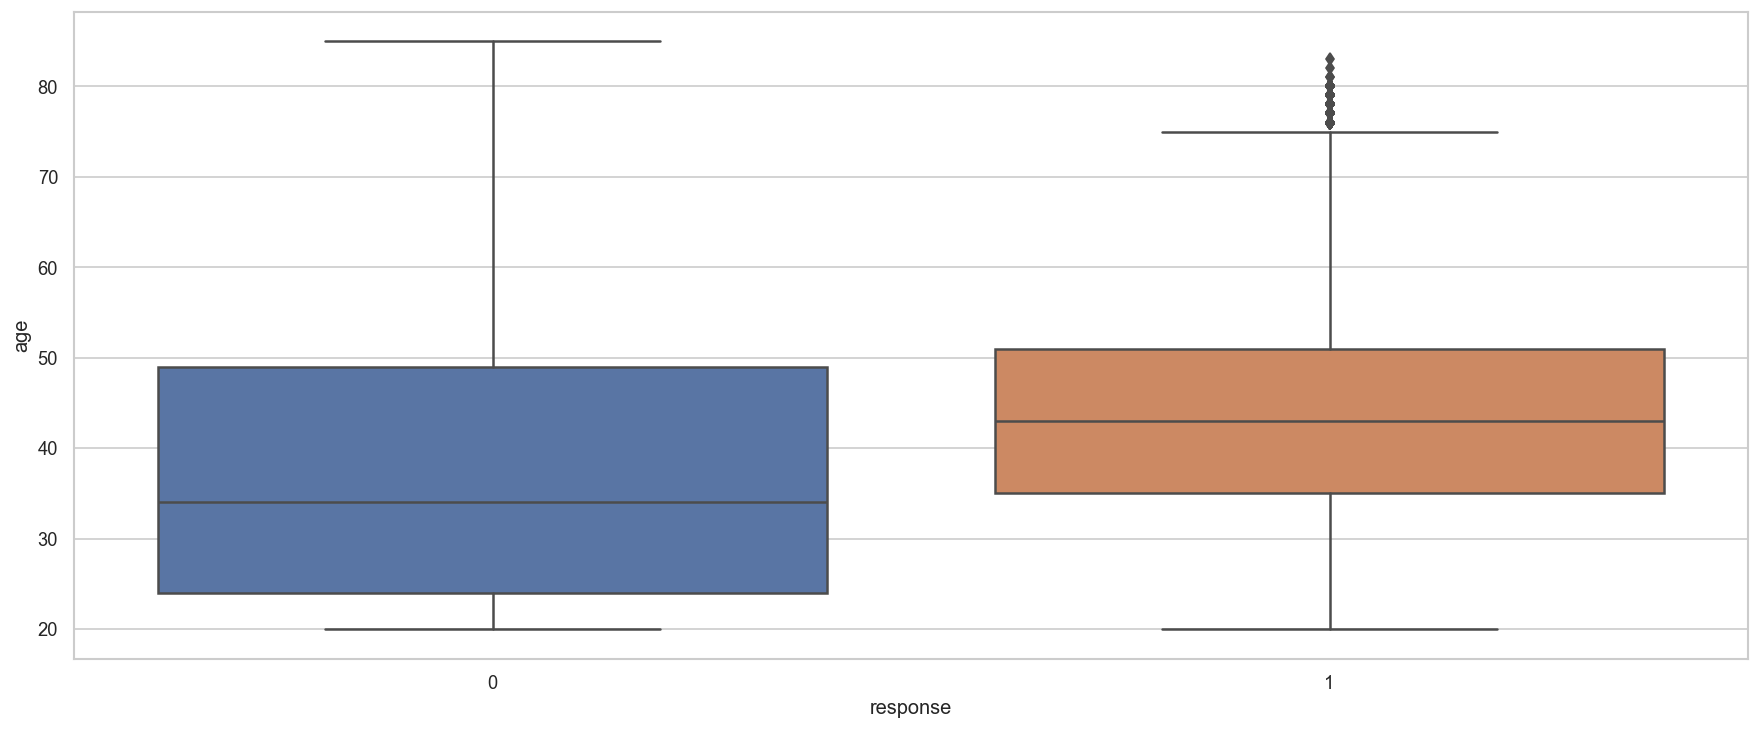

In [150]:
sns.boxplot(data=df4, x='response',y='age');

#### 4.1.8 - Num. Feature: response (TARGET)

#### 4.1.9 - Cat. feature: gender

#### 4.1.10 - Cat. Feature: vehicle_age

#### 4.1.11 - Cat. Feature: vehicle_damage

#### 4.1.1 - Numerical Features

In [ ]:
num_feat = num_attributes.columns
dt_num   = df4[num_feat]

In [ ]:
# Histogram plot to check the data distribution of the numerical variables:
n_features = len(num_feat)
n_rows = n_features // 3 + (n_features % 3 > 0) 
        
fig, axes = plt.subplots(n_rows, 3, figsize=(24, 12))  

for i, feature in enumerate(num_feat):
    row = i // 3  
    col = i % 3  
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    sns.histplot(data=dt_num, x=feature, kde=True, ax=ax)
    ax.set_title(feature, fontsize=15)  
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove unused axes.
    if n_features < len(axes.flat):
        for j in range(n_features, len(axes.flat)):
            fig.delaxes(axes.flat[j])
            
plt.tight_layout()
plt.show()

#### Analysis of **annual_premium** characteristic

In [ ]:
sns.boxplot(data=df4['annual_premium'], x=df4['annual_premium'])
plt.title('annual_premium', fontsize=15)

#  Quartiles
qt = df4['annual_premium'].describe(percentiles=[.25, .5, .75]).loc[['25%', '50%', '75%']]
qt

There are extremely values for this feature, however without more information about the business of the company it is not possible to consider them as part of the process or not.

Just to have an idea, 75% of the customers pay a max of 39400 as annual premium.

The approach I will assume is:

I will have a look into the extremely values and I will see how many interested customers have in there.

In [ ]:
df_annual_200 = df4[df4['annual_premium'] >= 200000 ] 

In [ ]:
df_annual_200.shape

In [ ]:
df_annual_200['response'].value_counts()

In [ ]:
df_annual_200[df_annual_200['response'] == 1]

In [ ]:
What I will do is, I will remove the data where the annual_premium is higher than 200.000 and they are interested. I now that these could be part of the process, however this approach may result in a better performance of the algorithm

**age** - StandardScaller will be applied;
**region_code** - StandardScaller
**policy_sales_channel** - MinMaxScaller
**driving_license** - 

**annual_premium** - RobustScaller
**vintage** - 
**vehicle_damage** - 
**gender** -
**previously_insured** - TargetEncoder


#### 4.1.2 - Categorical Features

In [ ]:
cat_feat = cat_attributes.columns
dt_cat = df4[cat_feat]

In [ ]:
n_features = len(cat_feat)
n_rows = n_features // 3 + (n_features % 3 > 0) 
        
fig, axes = plt.subplots(n_rows, 3, figsize=(24, 12))  

for i, feature in enumerate(cat_feat):
    row = i // 3  
    col = i % 3  
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    dt_count = dt_cat.groupby([feature])[[feature]].count().rename(columns={feature: 'count'}).reset_index()
    dt_count['perc'] = dt_count['count'] / dt_count['count'].sum() * 100
            
    ax.barh( y=dt_count[feature], width=dt_count['perc'])
    
    if pd.api.types.is_numeric_dtype(dt_count[feature]):
        ax.invert_yaxis()
        
    for index, value in enumerate(dt_count['perc']):
        ax.text(value + 0.5, index, f'{value:.1f}%', va='center') # Adjust the text position based on the width of the bars
    
    ax.set_yticks(ticks=range(dt_count[feature].nunique()), labels=dt_count[feature].tolist())
    ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(False)
            
    ax.set_title(feature, fontsize=15)   
    ax.set_xlabel('') 
    
    # Remove unused axes.
    if n_features < len(axes.flat):
        for j in range(n_features, len(axes.flat)):
            fig.delaxes(axes.flat[j])
            
plt.tight_layout()
plt.show()

#### 4.2.2 - Business Hyphotesis

In [ ]:
df4.head()

In [ ]:
#1.The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance. (FALSE)
d1 = df4[( df4['previously_insured'] == 0) & (df4['vehicle_damage'] == 'Yes')]

ax1 = d1[['response','id']].groupby('response').count().reset_index()
ax1['percentage'] = round(ax1['id'] / d1['id'].count()*100)
ax1['response'] = ax1['response'].apply(lambda x: 'No' if (x == 0) else 'Yes')

# Bar chart
fig1 = px.bar(ax1, x='response', 
              y='percentage', 
              color='response', 
              text='percentage', 
              width=1500,
              height=650,
              color_discrete_sequence=px.colors.qualitative.Pastel2)
fig1.update_traces(texttemplate='%{text:.2s}', 
                   textposition='outside')
fig1.update_layout(title_text="Hypothesis 1: Purchase Interest vs Vehicle Damage.", 
                   title_x=0.25,
                   font=dict(size=20))
fig1.show()

Hiphotesys is false once 75% of customers doesn't show interest in buying the vehicle insurance. 

In [ ]:
# 2. The interest on purchase the vehicle insurance is greater for woman than men. (FALSE)
ax2 = pd.crosstab(df4['gender'], df4['response'])
ax2['percentage'] = round(ax2[1]/(ax2[0]+ax2[1])*100)

# Creating new dataframe for a bar chart
aux2 = [['Female', 10],['Male',14]]
aux2_df = pd.DataFrame(aux2, columns=['gender','percentage'])

# Bar chart
fig = px.bar(aux2_df, 
             x='gender', 
             y='percentage', 
             color='gender', 
             text='percentage',
             width=1500,
             height=650, 
             color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')
fig.update_layout(title_text="Hypothesis 2: Purchase Interest vs Gender.", 
                   title_x=0.25,
                   font=dict(size=20))
fig.show()


Hiphotesys is false once 14% of the men show interest in buying the vehicle insurance against 10% of women. 

Hiphotesys is false, according the analysis, the period that the customers are with the company doesn't affect the interest in buying vehicle insurance. 

In [ ]:
# 3. The interest on purchase the vehicle insurance is greater for customers that spend less than 30k for annual premium.
aux5 = df4[df4['annual_premium'] > 30000][['id','response']]
aux6 = df4[df4['annual_premium'] <= 30000][['id','response']]

# Percentage of interested customers that spend more than 30k in annual premium
aux16 = aux5[['response','id']].groupby('response').count().reset_index()
aux16['percentage'] = round( aux16['id'] / aux5.shape[0] * 100 )

# Percentage of interested customers that spend less than 30k in annual premium
aux17 = aux6[['response','id']].groupby('response').count().reset_index()
aux17['percentage'] = round( aux17['id'] / aux6.shape[0] * 100 )

# Creating new dataframe for a bar chart
ax4 = [['30k or more in annual premium', 13],['30k or less in annual premium', 11]]
ax4_df = pd.DataFrame(ax4, columns=['annual_premium','percentage'])

# Bar chart
fig = px.bar(ax4_df,
             x='annual_premium',
             y='percentage', 
             color='annual_premium', 
             text='percentage', 
             width=1500, 
             height=650, 
             color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(texttemplate='%{text:.2s}',
                  textposition='outside')
fig.update_layout(title_text="Hypothesis 3: Purchase Interest vs Annual Premium",
                  title_x=0.17,
                  font=dict(size=20))
fig.show()

False, customers that spend more than 30k yearly show greter interest on purchase vehicle insurance.

In [ ]:
# 4. The interest on purchase the vehicle insurance is greater for customers that have driver license.
aux9 = pd.crosstab(df4['driving_license'], df4['response'])
aux9['percentage'] = round(aux9[1]/(aux9[0]+aux9[1])*100)

# Creating new dataframe for a bar chart
ax9 = [['No', 5 ],['Yes', 12]]
ax9_df = pd.DataFrame(ax9, columns=['driving_license','percentage'])

# Bar chart
fig = px.bar(ax9_df, 
             x='driving_license', 
             y='percentage', 
             color='driving_license', 
             text='percentage', 
             width=1500,
             height=650, 
             color_discrete_sequence=px.colors.qualitative.Pastel2 )
fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')
fig.update_layout(title_text="Hypothesis 4: Purchase Interest vs Driving License.", 
                  title_x=0.25,
                  font=dict(size=20))
fig.show()

In [ ]:
# 5. The interest on purchase the vehicle insurance is greater for customers that have new cars.
aux10 = pd.crosstab(df4['vehicle_age'], df4['response'])
aux10['percentage'] = round(aux10[1]/(aux10[0]+aux10[1])*100)

# Creating new dataframe for a bar chart
ax10 = [['New', 4 ],['Used', 17],['Old', 29]]
ax10_df = pd.DataFrame(ax10, columns=['vehicle_age','percentage'])

# Bar chart
fig = px.bar(ax10_df, 
             x='vehicle_age', 
             y='percentage', 
             color='vehicle_age', 
             text='percentage',
             width=1500,
             height=650,
             color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')
fig.update_layout(title_text="Hypothesis 5: Purchase Interest vs Vehicle Age.", 
                   title_x=0.25,
                   font=dict(size=20))
fig.show()

In [ ]:
# 6. The interest on purchase the vehicle insurance is greater for customers that have new cars and have damaged their vehicles.
aux11 = df4[(df4['vehicle_damage'] == 'Yes' )]
aux12 = pd.crosstab(aux11['vehicle_age'], aux11['response'])
aux12['percentage'] = round(aux12[1]/(aux12[0]+aux12[1])*100)

# Creating new dataframe for a bar chart
ax11 = [['New', 14 ],['Used', 27],['Old', 29]]
ax11_df = pd.DataFrame(ax11, columns=['vehicle_age','percentage'])

# Bar chart
fig = px.bar(ax11_df, 
             x='vehicle_age', 
             y='percentage', 
             color='vehicle_age', 
             text='percentage',
             width=1500,
             height=650, 
             color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')
fig.update_layout(title_text="Hypothesis 6: Purchase Interest vs New (damaged) cars.", 
                   title_x=0.25,
                   font=dict(size=20))
fig.show()

In [ ]:
# 7. The interest on purchase the vehicle insurance is lower for customers that are already insured.
aux15 = pd.crosstab(df4['previously_insured'], df4['response'])
aux15['percentage'] = round(aux15[1]/(aux15[0]+aux15[1])*100)
aux15

# Creating new dataframe for a bar chart
ax14 = [['No', 23 ],['Yes', 0]] 
ax14_df = pd.DataFrame(ax14, columns=['previously_insured','percentage'])

# Bar chart
fig = px.bar(ax14_df, 
             x='previously_insured', 
             y='percentage', 
             color='previously_insured', 
             text='percentage',
             width = 1500,
             height=650, 
             color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')
fig.update_layout(title_text="Hypothesis 7: Purchase Interest vs Previusly Insured.", 
                   title_x=0.25,
                   font=dict(size=20))
fig.show()


**Hypothesis Validation**

1. The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance.
    **False, of the customers that damaged their car and doesn't have insurance, only 25% show interest in acquire vehicle insurance.**

2. The interest on purchase the vehicle insurance is greater for woman than men.
    **False, only 10% of women show interest in acquire vehicle insurance, whereas 13% of the men show interest on acquire vehicle insurance.**

3. The interest on purchase vehicle insurance is greater for vintage customers ( 7 months or more ).
    **False, the period that customers are on the company doensn't show influency on interest in buying vehicle insurance.**

4. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
    **False, customers that spend more than 30k yearly show greter interest on purchase vehicle insurance.**

5. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
    **False, adults and elderlies show greater interest on buying vehicle insurance.**

6. The interest on purchase the vehicle insurance is greater for customers that have driver license.
    **True, arround 12% of customers that hold a driving license show interest in buying the vehicle insurance.**

7. The interest on purchase the vehicle insurance is greater for customers that have new cars.
    **False, the interest is greater for customers that own an old car.**

8. The interest on purchase the vehicle insurance is greater for customers that have new cars and have damaged their vehicles.
    **False, of the customers who damaged their car, the ones that own a old car show greater interest in buying the vehicle insurance (29%), followed by customers that own used cars (27%).**

9. The interest on purchase the vehicle insurance is greater for elderly women.
    **False, adult women show greater interest in buying the vehicle insurance.**

10. The interest on purchase the vehicle insurance is lower for customers that are already insured.
    **True, less than 1% of customers already insured show interest on purchase the vehicle insurance.**


### 4.3 - MULTIVARIATE ANALYSIS

In [ ]:
correlation = df2.corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True)

## 5 - DATA PREPARATION

In [ ]:
from feature_engine.transformation import PowerTransformer

In [ ]:
from feature_engine.encoding import WoEEncoder

In [ ]:
woe_encoder  = WoEEncoder(variables=['gender', 'vehicle_age', 'vehicle_damage'])
power_transform = PowerTransformer(variables=['id', 'age', 'region_code', 'policy_sales_channel', 'driving_license','previously_insured', 'annual_premium', 'vintage'])

### 5.1 - ML MODELS

In [ ]:
# Parameter "scale_pos_weight" definition

from collections import Counter

# ESTIMATE SCALE_POS_WEIGHT
counter = Counter(y_train)
estimate = counter[0]/counter[1]
print('Estimate: %.3f' % estimate)

#### Logistic Regression

In [ ]:
# Model Definition
clf_lr = LogisticRegression()

In [ ]:
# Pipeline
model_pipeline_lr = pipeline.Pipeline( steps = [("woe_encoder", woe_encoder),
                                                  ("power_transform", power_transform),
                                                  ("clf_lr", clf_lr)])

In [ ]:
cross_validation(5, 'lr', model_pipeline_lr, x_train, y_train, 20000)

In [ ]:
model_pipeline_lr.fit(x_train, y_train)

In [ ]:
yhat_lr_valid = model_pipeline_lr.predict_proba(x_valid)

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_valid, yhat_lr_valid, ax=axs[0],title='Cumulative Gain - Logistic Regression');

# Lift Curve
skplt.metrics.plot_lift_curve(y_valid, yhat_lr_valid,ax=axs[1],title='Lift Curve - Logistic Regression');

# Roc Curve
skplt.metrics.plot_roc(y_valid, yhat_lr_valid, ax=axs[2], title='ROC-Curve - Logistic Regression');

plt.tight_layout()

In [ ]:
# Precision and Recall @K
# As per Cumulative Gain chart, it is possible to identify that between 40% and 50% the model is able to find all interested customers.
aux = x_valid['id'].count()
k_value = 20000

precision_lr = precision_at_k_cv(y_valid, yhat_lr_valid, k_value)
recall_lr = recall_at_k_cv(y_valid, yhat_lr_valid, k_value)
LR_performance = ml_performance('LR', precision_lr, recall_lr )
LR_performance

#### XGB

In [ ]:
# Model Definition
clf_xgb = XGBClassifier(scale_pos_weight = estimate)

In [ ]:
# Pipeline
model_pipeline_xgb = pipeline.Pipeline( steps = [("woe_encoder", woe_encoder),
                                                  ("power_transform", power_transform),
                                                  ("clf_xgb", clf_xgb)])

In [ ]:
cross_validation(5, 'xgb', model_pipeline_xgb, x_train, y_train, 20000)

In [ ]:
model_pipeline_xgb.fit(x_train, y_train)

In [ ]:
yhat_xgb = model_pipeline_xgb.predict_proba(x_valid)

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_valid, yhat_xgb, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_valid, yhat_xgb, ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_valid, yhat_xgb, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [ ]:
# Precision and Recall @K

# As per Cumulative Gain chart, it is possible to identify that between 40% and 50% the model is able to find all interested customers.
aux = x_valid['id'].count()
k_value = 20000


precision_xgb = precision_at_k_cv(y_valid, yhat_xgb, k_value)
recall_xgb = recall_at_k_cv(y_valid, yhat_xgb, k_value)
XGB_performance = ml_performance('XGB', precision_xgb, recall_xgb )
XGB_performance

#### KNN

In [ ]:
# Model Definition
clf_knn = KNeighborsClassifier( n_neighbors = 8 )

In [ ]:
# Pipeline
model_pipeline_knn = pipeline.Pipeline( steps = [ ("woe_encoder", woe_encoder),
                                                  ("power_transform", power_transform),
                                                  ("clf_knn", clf_knn)])

In [ ]:
cross_validation(5, 'knn', model_pipeline_knn, x_train, y_train, 20000)

In [ ]:
model_pipeline_knn.fit(x_train, y_train)

In [ ]:
yhat_knn = model_pipeline_knn.predict_proba(x_valid)

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_valid, yhat_knn, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_valid, yhat_knn, ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_valid, yhat_knn, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [ ]:
# Precision and Recall @K
k_value = 20000


precision_knn = precision_at_k_cv(y_valid, yhat_knn, k_value)
recall_knn = recall_at_k_cv(y_valid, yhat_knn, k_value)
KNN_performance = ml_performance('KNN', precision_knn, recall_knn )
KNN_performance

## 9 - HYPERPARAMETER FINE TUNING

### 9.1 - XGB Fine Tuning

In [ ]:
# XGB
def objective_xgb(trial):
    """Define the objective function"""
    params = {
        'clf_xgb__max_depth': trial.suggest_int('clf_xgb__max_depth', 5, 20),
        'clf_xgb__eta': trial.suggest_float('clf_xgb__eta', 0.01, 0.05),
        'clf_xgb__learning_rate': trial.suggest_loguniform('clf_xgb__learning_rate', 0.01, 1.0),
        'clf_xgb__n_estimators': trial.suggest_int('clf_xgb__n_estimators', 100, 1000),
        'clf_xgb__min_child_weight': trial.suggest_int('clf_xgb__min_child_weight', 1, 15),
        'clf_xgb__gamma': trial.suggest_loguniform('clf_xgb__gamma', 1e-8, 1.0),
        'clf_xgb__subsample': trial.suggest_loguniform('clf_xgb__subsample', 0.01, 1.0),
        'clf_xgb__colsample_bytree': trial.suggest_loguniform('clf_xgb__colsample_bytree', 0.1, 1.0),
        'clf_xgb__reg_alpha': trial.suggest_loguniform('clf_xgb__reg_alpha', 1e-8, 1.0),
        'clf_xgb__reg_lambda': trial.suggest_loguniform('clf_xgb__reg_lambda', 1e-8, 1.0),
        'clf_xgb__eval_metric': 'mlogloss'
    }

    # Fit the model
    model_pipeline_xgb.set_params(**params)
    model_pipeline_xgb.fit(x_train, y_train)

    # Make predictions
    optuna_xgb_pred = model_pipeline_xgb.predict_proba(x_valid)

    # Evaluate predictions
    aux = x_valid['id'].count()
    k_value = round(0.4 * aux)
    k_value
    recall_atK = recall_at_k_cv(y_valid, optuna_xgb_pred, k_value)
    return  recall_atK

In [ ]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=2)

In [ ]:
print('Number of finished trials: {}'.format(len(study_xgb.trials)))
print('Best trial:')
trial = study_xgb.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
param_xgb = {'scale_pos_weight': estimate,
             'max_depth': 6,
             'eta': 0.0310260525237683,
             'learning_rate': 0.03914508739999509,
             'n_estimators': 619,
             'min_child_weight': 9,
             'gamma': 3.06408087126589e-05,
             'subsample': 0.3640515535413122,
             'colsample_bytree': 0.449945653612218,
             'reg_alpha': 0.143727642904309,
             'reg_lambda': 0.020464155005749916
            }

## 9.3 - ML Model After Tuning

In [ ]:
x_lasttrain = pd.concat([x_train, x_valid], axis=0)
y_lasttrain = pd.concat([y_train, y_valid], axis=0)

### XGB After Tuning

In [ ]:
# Model Definition
clf_xgb_ft = XGBClassifier(**param_xgb)


In [ ]:
# Pipeline
model_pipeline_xgb_ft = pipeline.Pipeline( steps = [("woe_encoder", woe_encoder),
                                                   ("power_transform", power_transform),
                                                   ("clf_xgb_ft", clf_xgb_ft)])

In [ ]:
model_pipeline_xgb_ft.fit(x_lasttrain, y_lasttrain)

In [ ]:
yhat_xgb_ft = model_pipeline_xgb_ft.predict_proba(x_test)

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb_ft, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_test, yhat_xgb_ft,ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_test, yhat_xgb_ft, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [ ]:
# Precision and Recall @K
k_value = 20000


precision_xgb_ft = precision_at_k_cv(y_test, yhat_xgb_ft, k_value)
recall_xgb_ft = recall_at_k_cv(y_test, yhat_xgb_ft, k_value)
KNN_performance = ml_performance('XGB FT', precision_xgb_ft, recall_xgb_ft )
KNN_performance

In [ ]:
# Precision and Recall @K
cross_validation(5, 'xgb_tuned', model_pipeline_xgb_ft, x_lasttrain, y_lasttrain, 20000)

## 10 - DEPLOYING MODEL TO PRODUCTION

### 10.1 - HEALTHINSURANCE CLASS

In [ ]:
import pickle
import inflection
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path                                = ''
        self.frequency_encode_policy_sales_scaler     = pickle.load( open( self.home_path + 'src/features/frequency_encode_policy_sales_scaler.pkl', 'rb') )
        self.frequency_encode_region_code_scaler      = pickle.load( open( self.home_path + 'src/features/frequency_encode_region_code_scaler.pkl', 'rb') )
        self.target_encode_gender_scaler              = pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb') )
        self.target_encode_vintage_month_scaler       = pickle.load( open( self.home_path + 'src/features/target_encode_vintage_month_scaler.pkl', 'rb') )
        self.age_scaler                               = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.avg_vehicle_damage_region_code_scaler    = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.avg_vintage_age_scaler                   = pickle.load( open( self.home_path + 'src/features/avg_vintage_age_scaler.pkl', 'rb') )
        self.vintage_scaler                           = pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb') )
        self.age_premium_scaler                       = pickle.load( open( self.home_path + 'src/features/age_premium_scaler.pkl', 'rb') )
        self.annual_premium_scaler                    = pickle.load( open( self.home_path + 'src/features/age_premium_scaler.pkl', 'rb') )
        self.avg_day_premium_policy_scaler            = pickle.load( open( self.home_path + 'src/features/avg_day_premium_policy_scaler.pkl', 'rb') )
        self.day_premium_scaler                       = pickle.load( open( self.home_path + 'src/features/day_premium_scaler.pkl', 'rb') )
        self.median_premium_by_region_scaler          = pickle.load( open( self.home_path + 'src/features/median_premium_by_region_scaler.pkl', 'rb') )
        self.region_premium_scaler                    = pickle.load( open( self.home_path + 'src/features/region_premium_scaler.pkl', 'rb') )
    
    def data_cleaning( self, df5 ):
 
        ## rename Columns
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df5.columns = cols_new
        
        return( df5 )

    def feature_engineering( self, df5 ):
        
        # Fitting vehicle_age column
        df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)

        # Fitting vehicle_damage column
        df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)
        
        # median_premium_by_region
        dict_region_code = df5[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
        df5['median_premium_by_region'] = df5['region_code'].map(dict_region_code)

        # moda policy sales chanel por idade
        mode_policy_per_age = df5[['age', 'policy_sales_channel']].groupby('age').agg(pd.Series.mode).to_dict(orient='dict')['policy_sales_channel']
        df5['mode_policy_per_age'] = df5['age'].map(mode_policy_per_age)

        # Media de carros danificados por idade
        avg_carros_danificados_idade = df5[['age', 'vehicle_damage']].groupby('age').mean().to_dict(orient='dict')['vehicle_damage']
        df5['avg_vehicle_damage_per_age'] = df5['age'].map(avg_carros_danificados_idade)

        # Media de carros danificados por regiao
        avg_carros_danificados_regiao = df5[['age', 'region_code']].groupby('age').mean().to_dict(orient='dict')['region_code']
        df5['avg_vehicle_damage_region_code'] = df5['age'].map(avg_carros_danificados_regiao)

        # age_group feature creation
        df5['age_group'] = df5['age'].apply(lambda x: 1 if (x >= 18 | x < 30 ) else 2 if (x >= 30 | x < 60 ) else 3)

        # vintage_month feature cration
        df5['vintage_month'] = round(df5['vintage'] / 31)

        # day_premium feature creation
        df5['day_premium'] = df5['annual_premium']/df5['vintage']

        # age_premium feature cration
        df5['age_premium'] = df5['annual_premium']/df5['age']

        # Calculating Median Annual Premium by Region_code
        premium_rc = df5[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
        df5['region_premium'] = df5['region_code'].map(premium_rc)

        # Calculating Median Aday_premium per policy_sales_channel
        day_premium_psc = df5[['day_premium', 'policy_sales_channel']].groupby('policy_sales_channel').mean().to_dict(orient='dict')['day_premium']
        df5['avg_day_premium_policy'] = df5['policy_sales_channel'].map(day_premium_psc)

        # avg vintage per age
        avg_vintage_per_age = df5[['age', 'vintage']].groupby('age').mean().to_dict(orient='dict')['vintage']
        df5['avg_vintage_age'] = df5['age'].map(avg_vintage_per_age)
        
        return( df5 )
    
    def data_preparation( self, df5 ):
              
        # STANDARDIZATION

        # annual premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # age_premium
        df5['age_premium'] = self.age_premium_scaler.transform( df5[['age_premium']].values )

        # day_premium
        df5['day_premium'] = self.day_premium_scaler.transform( df5[['day_premium']].values )

        # avg_day_premium_policy
        df5['avg_day_premium_policy'] = self.avg_day_premium_policy_scaler.transform( df5[['avg_day_premium_policy']].values )

        # median_premium_by_region
        df5['median_premium_by_region'] = self.median_premium_by_region_scaler.transform( df5[['median_premium_by_region']].values )

        # region_premium
        df5['region_premium'] = self.region_premium_scaler.transform( df5[['region_premium']].values )



        # REESCALING

        # age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # avg_vintage_age
        df5['avg_vintage_age'] = self.avg_vintage_age_scaler.transform( df5[['avg_vintage_age']].values )

        # vintage_month
        df5['vintage_month'] = self.vintage_scaler.transform( df5[['vintage_month']].values )

        # avg_vehicle_damage_region_code
        df5['avg_vehicle_damage_region_code'] = self.avg_vehicle_damage_region_code_scaler.transform( df5[['avg_vehicle_damage_region_code']].values )



        # ENCODER

        # policy sales channel
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.frequency_encode_policy_sales_scaler )

        # region code
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.frequency_encode_region_code_scaler )

        # gender
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # vintage_month
        df5.loc[:, 'vintage_month'] = df5['vintage_month'].map( self.target_encode_vintage_month_scaler )

        # FILL NAN VALUES
        x_valid = x_valid.fillna(0)
        
        # Feature Selection
        cols_selected = ['vehicle_damage','previously_insured','vintage','day_premium','age_premium','annual_premium','vintage_month','region_code','avg_vehicle_damage_per_age','policy_sales_channel','age','median_premium_by_region','region_premium',
                         'avg_day_premium_policy','vehicle_age','avg_vehicle_damage_region_code','avg_vintage_age','gender']
        
        return df5[cols_selected]
    

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict_proba( test_data )
        
        # join pred into the original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

### 10.2 - API HANDLER

In [ ]:
import pickle
import pandas as pd
import os
from flask                           import Flask, request, Response
from healthinsurance.healthinsurance import HealthInsurance

# logading model
model = pickle.load( open( 'src/models/xgb_model.pkl', 'rb' ) )
                          
# initialize API
app = Flask( __name__ )

@app.route( '/healthinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
               
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
    
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) # multiple examples
            
        # Instantiate Rossmann Class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
              
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # Data Preparation
        df3 = pipeline.data_preparation( df2 )
                              
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run('0.0.0.0')

#    port = os.environ.get('PORT', 5000)
#    app.run( host='0.0.0.0', port=port )

## 11 - BUSINESS QUESTIONS

In [ ]:
df_11 = pd.concat([x_test, y_test], axis=1)

In [ ]:
df_11['prediction'] = yhat_lgbm_ft[:,1]

In [ ]:
df_11.head()

### 1 - What percentage of customers interested in purchasing a car insurance will the sales team be able to contact by making 20,000 calls?

In [ ]:
n = 20000
ax1 = df_11['id'][(df_11['prediction'] > 0.5)].count()
q1 = df_11.sort_values(by='prediction', ascending=False)
ax2 = q1.iloc[:20000]
ax3 = (ax2['response'] == 1).sum()
ax4 = (df_11['response'] == 1).sum()

print(f'Numbers os contacts: {n} ({n/len(df_11):.2%})')
print(f'Will impact {ax3/ax4:.2%} of interested customers')

### 2 -  And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing a car insurance will the sales team be able to contact?

In [ ]:
n = 40000
ax1 = df_11['id'][(df_11['prediction'] > 0.5)].count()
q1 = df_11.sort_values(by='prediction', ascending=False)
ax2 = q1.iloc[:40000]
ax3 = (ax2['response'] == 1).sum()
ax4 = (df_11['response'] == 1).sum()

print(f'Numbers os contacts: {n} ({n/len(df_11):.2%})')
print(f'Will impact {ax3/ax4:.2%} of interested customers')

### 3 - How many calls does the sales team need to make to contact 80% of customers interested in purchasing a car insurance?

In [ ]:
n = 20000
ax1 = df_11['id'][(df_11['prediction'] > 0.5)].count()
q1 = df_11.sort_values(by='prediction', ascending=False)
ax2 = q1.iloc[:23500]
ax3 = (ax2['response'] == 1).sum()
ax4 = (df_11['response'] == 1).sum()

print(f'Numbers os contacts: {n} ({n/len(df_11):.2%})')
print(f'Will impact {ax3/ax4:.2%} of interested customers')